## Anomaly Detection using sequence-to-sequence LSTM autoencoder with attention

In [29]:
# Imports 
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [30]:
# Configuration class
class Config:
    def __init__(self):
        # Paths
        self.base_path = Path(r"C:\Users\House\OneDrive\Documents\Sohan_Arun\BTH Course Work\Deep Learning\Assignment 2")
        self.data_path = self.base_path / "data"
        
        # Model parameters
        self.window_size = 10
        self.stride = 5
        self.hidden_sizes = (128, 32)  # (h1, h2)
        self.dropout_enc = 0.1
        self.dropout_dec = 0.1
        self.batch_size = 32
        self.num_epochs = 100
        self.patience = 10
        self.bottleneck = "mean_pool"
        self.min_anomaly_windows = 100

# Create global config
cfg = Config()

# Set device and seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
print(f"Using device: {device}")



Using device: cuda


In [ ]:
# Model Architecture
class BahdanauAttention(nn.Module):
    def __init__(self, enc_dim: int, dec_dim: int, attn_dim: int = 64):
        super().__init__()
        self.W_e = nn.Linear(enc_dim, attn_dim, bias=False)
        self.W_d = nn.Linear(dec_dim, attn_dim, bias=False)
        self.v = nn.Linear(attn_dim, 1, bias=False)

    def forward(self, encoder_out: torch.Tensor, hidden: torch.Tensor):
        time_steps = encoder_out.size(1)
        hidden = hidden.unsqueeze(1).repeat(1, time_steps, 1)
        energy = torch.tanh(self.W_e(encoder_out) + self.W_d(hidden))
        score = self.v(energy).squeeze(-1)
        attn_weights = torch.softmax(score, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_out).squeeze(1)
        return context, attn_weights

  
    
class Seq2SeqAttentionAE(nn.Module):
    def __init__(self, input_dim: int):
        super().__init__()
        h1, h2 = cfg.hidden_sizes
        
        # Encoders - Remove dropout for single layer LSTMs
        self.encoder = nn.LSTM(input_dim, h1, batch_first=True,
                              bidirectional=False)
        self.encoder2 = nn.LSTM(h1, h2, batch_first=True,
                               bidirectional=False)
        
        # Add dropout layers explicitly instead
        self.dropout_enc = nn.Dropout(cfg.dropout_enc)
        
        # Attention and Decoder
        self.attn = BahdanauAttention(enc_dim=h2, dec_dim=h2)
        self.decoder = nn.LSTM(h2 + input_dim, h2, batch_first=True)
        self.dropout_dec = nn.Dropout(cfg.dropout_dec)
        self.fc = nn.Linear(h2, input_dim)
        
        self.apply(self._init_weights)
    
    
    @staticmethod
    def _init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # Encoding
        enc_out, _ = self.encoder(x)
        enc_out, (h_T, c_T) = self.encoder2(enc_out)
        
        # Get hidden state
        if cfg.bottleneck == "mean_pool":
            h = enc_out.mean(dim=1)
        else:
            h = h_T.squeeze(0)
        
        # Decoding with attention
        B, T, F = x.size()
        prev_output = torch.zeros(B, F, device=x.device)
        outputs = []
        attn_weights_all = []
        dec_hidden = (h.unsqueeze(0), torch.zeros_like(h.unsqueeze(0)))
        
        for t in range(T):
            context, attn_w = self.attn(enc_out, dec_hidden[0].squeeze(0))
            dec_input = torch.cat([prev_output, context], dim=-1).unsqueeze(1)
            dec_out, dec_hidden = self.decoder(dec_input, dec_hidden)
            out_t = self.fc(dec_out.squeeze(1))
            outputs.append(out_t)
            attn_weights_all.append(attn_w)
            prev_output = out_t
        
        outputs = torch.stack(outputs, dim=1)
        attn_weights_all = torch.stack(attn_weights_all, dim=1)
        return outputs, attn_weights_all



In [ ]:
# Data Processing Functions
def get_channel_names(base_path=Path(".")):
    """Get channel names from train directory"""
    train_path = base_path / "data" / "train"
    channels = [f.stem for f in train_path.glob("*.npy")]
    return sorted(channels)

def create_sliding_windows(data, window_size, stride=None):
    """Create sliding windows from data"""
    if stride is None:
        stride = window_size // 2
    windows = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i + window_size])
    return np.array(windows)

def load_and_preprocess_data(channel_name, base_path):
    """Load and preprocess data for a channel"""
    # Load data
    train_data = np.load(base_path / "data" / "train" / f"{channel_name}.npy")
    test_data = np.load(base_path / "data" / "test" / f"{channel_name}.npy")
    
    # Load labels
    labels_df = pd.read_csv(base_path / "data" / "labeled_anomalies.csv")
    channel_labels = labels_df[labels_df['chan_id'] == channel_name]
    
    if channel_labels.empty:
        print(f"\n⚠️ WARNING: No labels found for channel {channel_name}")
        return None
    
    channel_info = channel_labels.iloc[0]
    
    # Scale data
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data)
    test_data = scaler.transform(test_data)
    
    # Create windows
    train_windows = create_sliding_windows(train_data, cfg.window_size, cfg.stride)
    test_windows = create_sliding_windows(test_data, cfg.window_size, cfg.stride)
    
    # Create labels
    test_labels = np.zeros(len(test_windows))
    
    sequences = eval(channel_info['anomaly_sequences'])
    for start, end in sequences:
        window_start = start // cfg.stride
        window_end = end // cfg.stride
        test_labels[window_start:window_end + 1] = 1
    
    print(f"Channel {channel_name}:")
    print(f"Total windows: {len(test_windows)}")
    print(f"Anomaly windows: {int(test_labels.sum())}")
    print(f"Anomaly class: {channel_labels['class']}")
    
    return train_windows, test_windows, test_labels, scaler



In [ ]:
# Training Functions
def train_model(model, train_loader, val_loader, device, channel_name, scaler):
    """Train model"""
    
    optimizer = torch.optim.Adam(model.parameters())
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, verbose=True)

    criterion = nn.MSELoss()
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(cfg.num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            
            optimizer.zero_grad()
            reconstructed, _ = model(x)
            
            loss = criterion(reconstructed, x)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                reconstructed, _ = model(x)
                val_loss += criterion(reconstructed, x).item()
        
        val_loss = val_loss / len(val_loader)
        
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")
        
        # Checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= cfg.patience:
                print("Early stopping!")
                break
    
    return best_val_loss



In [35]:
def plot_metrics(channel_name, anomaly_scores, threshold, test_labels, predicted_labels):
    """Plot evaluation metrics including AUPRC"""
    

    # Create a 2x2 subplot figure
    plt.figure(figsize=(15, 12))
    
    # First subplot - Anomaly Scores
    plt.subplot(2, 2, 1)
    plt.plot(anomaly_scores, label='Anomaly Score')
    plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    
    # Add red dots for true anomalies
    anomaly_indices = np.where(test_labels == 1)[0]
    plt.scatter(anomaly_indices, anomaly_scores[anomaly_indices], 
                color='red', s=40, marker='o', label='True Anomalies')
    
    plt.title(f'Anomaly Scores - {channel_name}')
    plt.legend()
    
    # Second subplot - Confusion matrix
    plt.subplot(2, 2, 2)
    cm = confusion_matrix(test_labels, predicted_labels)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix - {channel_name}')
    
    # Third subplot - ROC curve
    plt.subplot(2, 2, 3)
    auroc = roc_auc_score(test_labels, anomaly_scores)
    fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)
    plt.plot(fpr, tpr, label=f'AUC = {auroc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    
    # Fourth subplot - Precision-Recall curve
    plt.subplot(2, 2, 4)
    auprc = average_precision_score(test_labels, anomaly_scores)
    precision, recall, pr_thresholds = precision_recall_curve(test_labels, anomaly_scores)
    plt.plot(recall, precision, label=f'AUPRC = {auprc:.3f}')
    
    # Add baseline (no-skill classifier line)
    baseline = sum(test_labels)/len(test_labels)
    plt.axhline(y=baseline, color='r', linestyle='--', 
               label=f'Baseline = {baseline:.4f}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\nMetrics:")
    print(f"Accuracy: {accuracy_score(test_labels, predicted_labels):.3f}")
    print(f"Precision: {precision_score(test_labels, predicted_labels, zero_division=0):.3f}")
    print(f"Recall: {recall_score(test_labels, predicted_labels, zero_division=0):.3f}")
    print(f"F1: {f1_score(test_labels, predicted_labels, zero_division=0):.3f}")
    print(f"AUROC: {auroc:.3f}")
    print(f"AUPRC: {auprc:.3f} (Baseline: {baseline:.4f})")

In [36]:
# Main Execution
def process_all_channels(base_path=cfg.base_path, min_anomaly_windows=cfg.min_anomaly_windows):
    """Process all channels and return results"""
    channels = get_channel_names(base_path)
    results = {}
    skipped_channels = []
    
    for channel in channels:
        print(f"\n{'='*50}")
        print(f"Processing channel {channel}")
        print(f"{'='*50}")
        
        # Load and preprocess
        preprocessing_result = load_and_preprocess_data(channel, base_path)
        
        if preprocessing_result is None:
            skipped_channels.append({'channel': channel, 'reason': 'No labels found'})
            continue
        
        
        # Unpack the result tuple
        train_windows, test_windows, test_labels, scaler = preprocessing_result
        

        
        
        # Check for minimum anomaly windows
        anomaly_count = int(test_labels.sum())
        if anomaly_count < min_anomaly_windows:
            skipped_channels.append({
                'channel': channel,
                'anomaly_count': anomaly_count,
                'reason': f'Insufficient anomaly windows (minimum {min_anomaly_windows} required)'
            })
            print(f"\n⚠️ WARNING: Skipping channel {channel} Insufficient anomaly windows")
            # print(f"Found only {anomaly_count} anomaly windows (minimum {min_anomaly_windows} required)")
            continue
        
        
        # Create dataloaders
        train_windows, val_windows = train_test_split(train_windows, test_size=0.2)
        train_loader = DataLoader(
            TensorDataset(torch.FloatTensor(train_windows)),
            batch_size=cfg.batch_size, shuffle=True
        )
        val_loader = DataLoader(
            TensorDataset(torch.FloatTensor(val_windows)),
            batch_size=cfg.batch_size
        )
        
        # Create and train model
        input_dim = train_windows.shape[2]
        model = Seq2SeqAttentionAE(input_dim=input_dim).to(device)
        train_model(model, train_loader, val_loader, device, channel, scaler)
        
        # Get predictions
        model.eval()
        with torch.no_grad():
            test_tensor = torch.FloatTensor(test_windows).to(device)
            reconstructed, _ = model(test_tensor)
            reconstruction_errors = torch.mean((test_tensor - reconstructed) ** 2, dim=(1,2))
        
        # Calculate scores and predictions
        anomaly_scores = reconstruction_errors.cpu().numpy()
        
        
        threshold = np.percentile(anomaly_scores, 70)
        
        
        
        predicted_labels = (anomaly_scores > threshold).astype(int)
        
        # Plot and store results
        plot_metrics(channel, anomaly_scores, threshold, test_labels, predicted_labels)
        results[channel] = {
            'scores': anomaly_scores,
            'predictions': predicted_labels,
            'labels': test_labels
        }
    
    return results




Processing channel A-1
Channel A-1:
Total windows: 1727
Anomaly windows: 17
Anomaly class: 15    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel A-1 Insufficient anomaly windows

Processing channel A-2
Channel A-2:
Total windows: 1581
Anomaly windows: 23
Anomaly class: 22    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel A-2 Insufficient anomaly windows

Processing channel A-3
Channel A-3:
Total windows: 1640
Anomaly windows: 38
Anomaly class: 23    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel A-3 Insufficient anomaly windows

Processing channel A-4
Channel A-4:
Total windows: 1615
Anomaly windows: 23
Anomaly class: 24    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel A-4 Insufficient anomaly windows

Processing channel A-5
Channel A-5:
Total windows: 937
Anomaly windows: 11
Anomaly class: 47    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel A-5 Insufficient anomaly windows

Proce

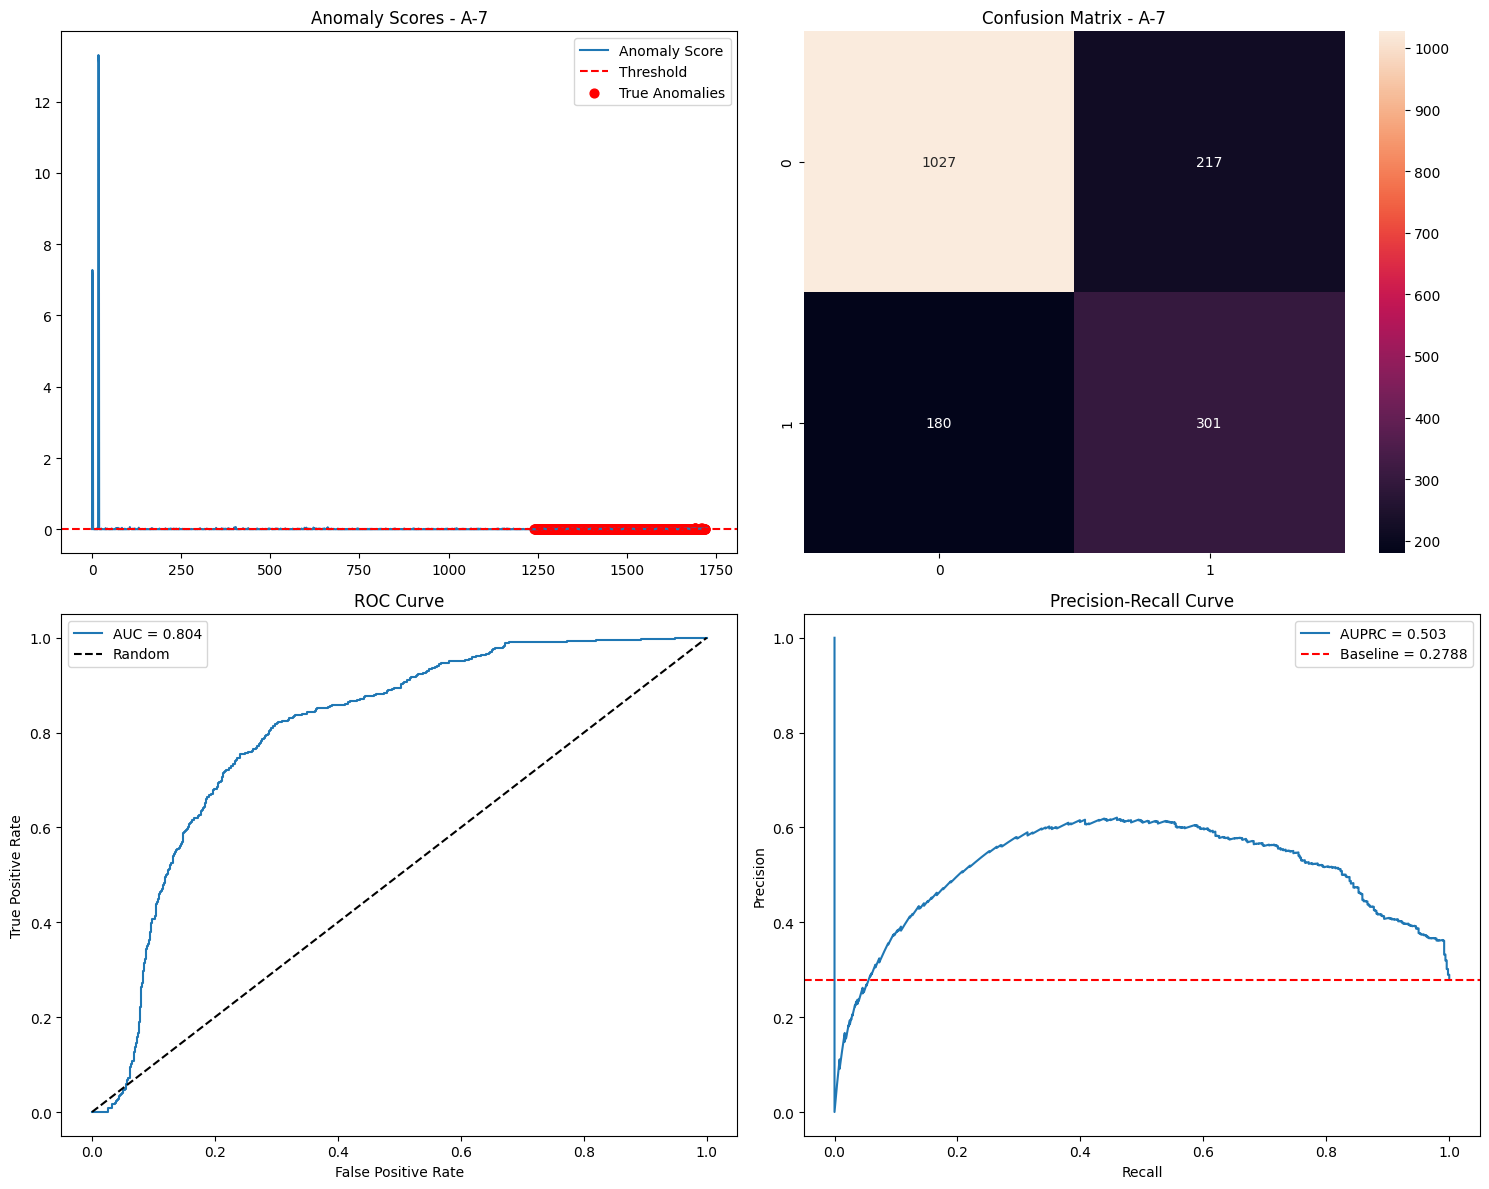


Metrics:
Accuracy: 0.770
Precision: 0.581
Recall: 0.626
F1: 0.603
AUROC: 0.804
AUPRC: 0.503 (Baseline: 0.2788)

Processing channel A-8
Channel A-8:
Total windows: 1674
Anomaly windows: 761
Anomaly class: 52    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.3671, Val Loss: 0.5241
Epoch 2, Train Loss: 0.3622, Val Loss: 0.5208
Epoch 3, Train Loss: 0.3939, Val Loss: 0.5167
Epoch 4, Train Loss: 0.3513, Val Loss: 0.5101
Epoch 5, Train Loss: 0.3391, Val Loss: 0.5040
Epoch 6, Train Loss: 0.3671, Val Loss: 0.4991
Epoch 7, Train Loss: 0.3364, Val Loss: 0.4937
Epoch 8, Train Loss: 0.3448, Val Loss: 0.4901
Epoch 9, Train Loss: 0.3265, Val Loss: 0.4874
Epoch 10, Train Loss: 0.3446, Val Loss: 0.4852
Epoch 11, Train Loss: 0.3375, Val Loss: 0.4840
Epoch 12, Train Loss: 0.3176, Val Loss: 0.4831
Epoch 13, Train Loss: 0.3162, Val Loss: 0.4829
Epoch 14, Train Loss: 0.3097, Val Loss: 0.4835
Epoch 15, Train Loss: 0.3078, Val Loss: 0.4835
Epoch 16, Train Loss: 0.3034, Val Loss: 0.4826
Epoch 

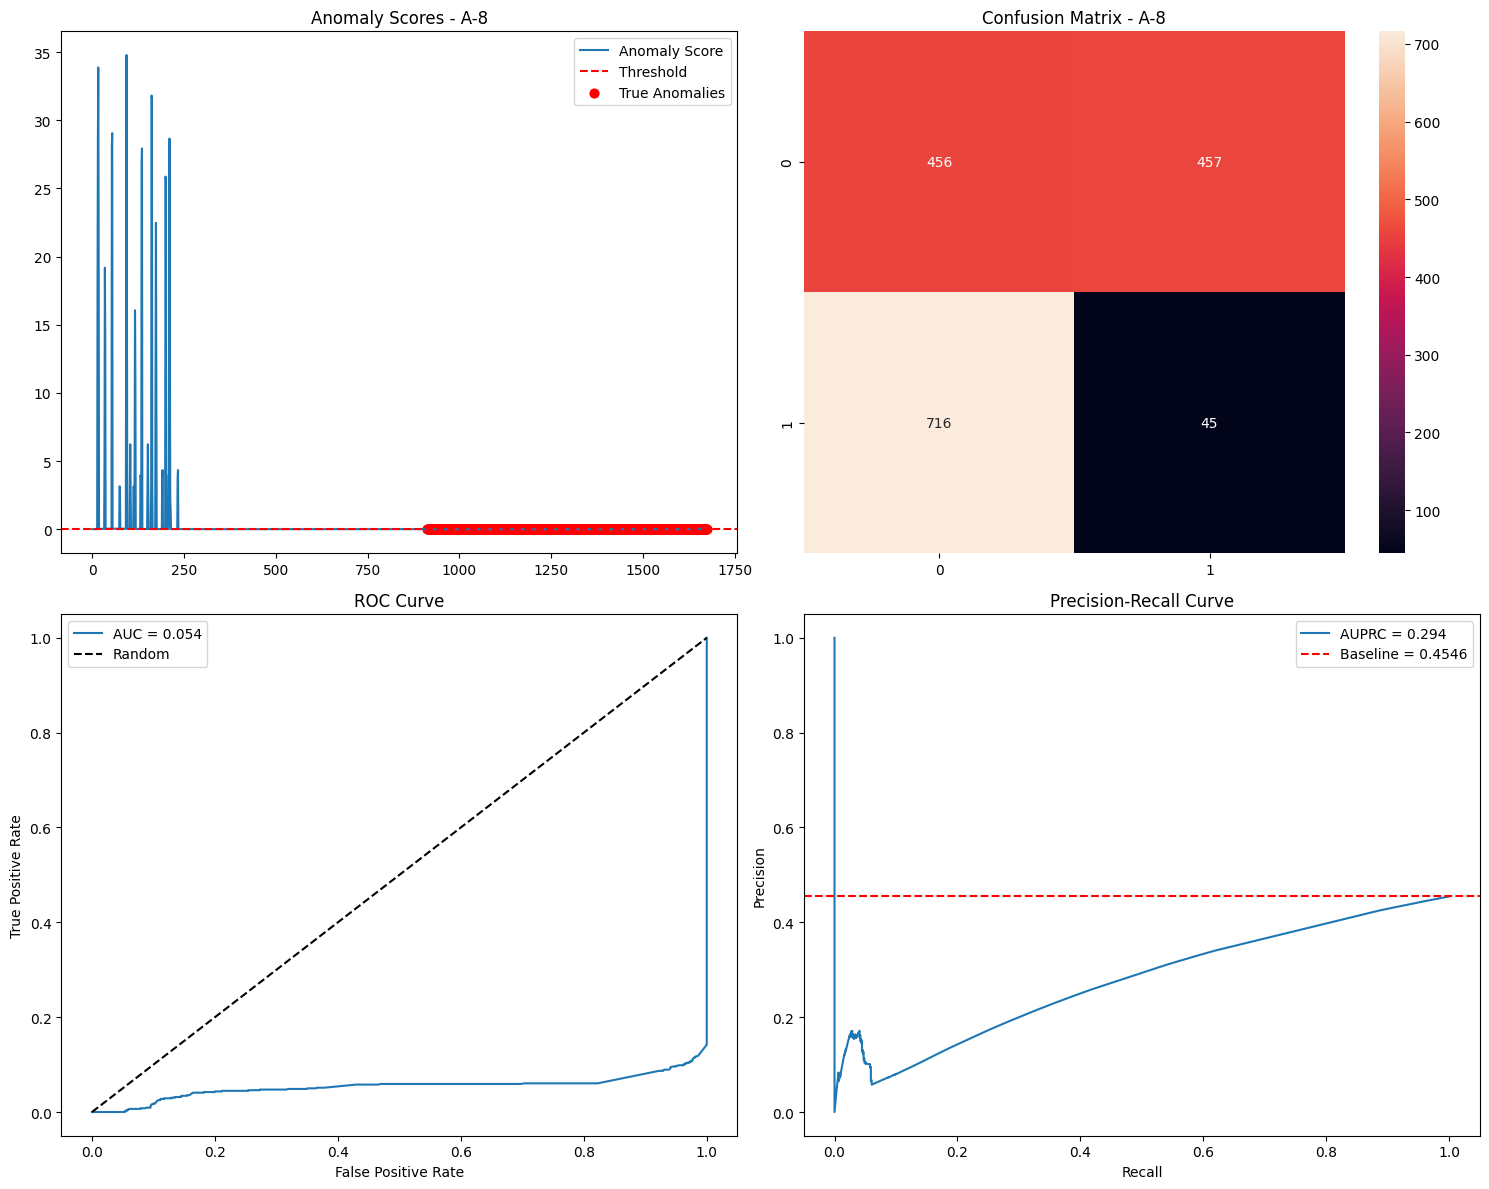


Metrics:
Accuracy: 0.299
Precision: 0.090
Recall: 0.059
F1: 0.071
AUROC: 0.054
AUPRC: 0.294 (Baseline: 0.4546)

Processing channel A-9
Channel A-9:
Total windows: 1685
Anomaly windows: 772
Anomaly class: 53    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.3229, Val Loss: 0.6628
Epoch 2, Train Loss: 0.3443, Val Loss: 0.6604
Epoch 3, Train Loss: 0.3473, Val Loss: 0.6571
Epoch 4, Train Loss: 0.3111, Val Loss: 0.6514
Epoch 5, Train Loss: 0.3211, Val Loss: 0.6427
Epoch 6, Train Loss: 0.2936, Val Loss: 0.6343
Epoch 7, Train Loss: 0.3179, Val Loss: 0.6279
Epoch 8, Train Loss: 0.2806, Val Loss: 0.6246
Epoch 9, Train Loss: 0.2856, Val Loss: 0.6230
Epoch 10, Train Loss: 0.2930, Val Loss: 0.6218
Epoch 11, Train Loss: 0.2963, Val Loss: 0.6200
Epoch 12, Train Loss: 0.2897, Val Loss: 0.6185
Epoch 13, Train Loss: 0.3119, Val Loss: 0.6175
Epoch 14, Train Loss: 0.2836, Val Loss: 0.6165
Epoch 15, Train Loss: 0.2974, Val Loss: 0.6163
Epoch 16, Train Loss: 0.2809, Val Loss: 0.6160
Epoch 

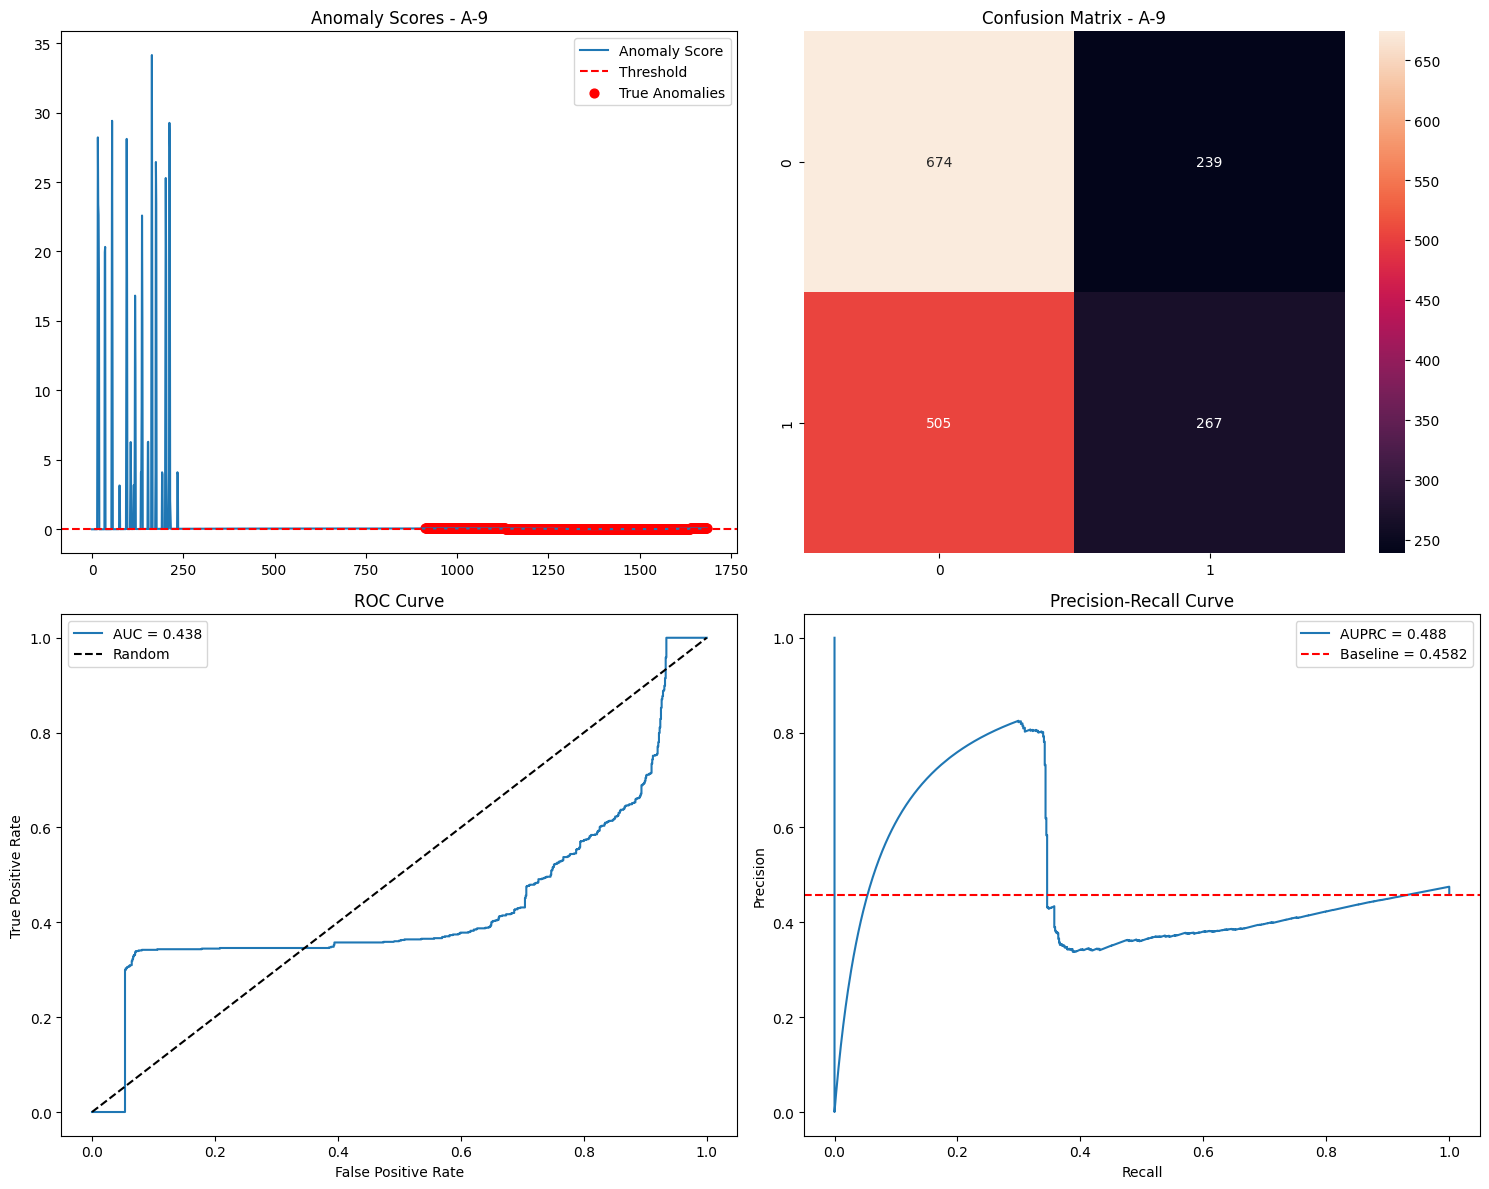


Metrics:
Accuracy: 0.558
Precision: 0.528
Recall: 0.346
F1: 0.418
AUROC: 0.438
AUPRC: 0.488 (Baseline: 0.4582)

Processing channel B-1
Channel B-1:
Total windows: 1607
Anomaly windows: 15
Anomaly class: 42    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel B-1 Insufficient anomaly windows

Processing channel C-1
Channel C-1:
Total windows: 451
Anomaly windows: 64
Anomaly class: 67    [point, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel C-1 Insufficient anomaly windows

Processing channel C-2
Channel C-2:
Total windows: 409
Anomaly windows: 29
Anomaly class: 68    [point, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel C-2 Insufficient anomaly windows

Processing channel D-1
Channel D-1:
Total windows: 1700
Anomaly windows: 650
Anomaly class: 16    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.6670, Val Loss: 0.7547
Epoch 2, Train Loss: 0.6553, Val Loss: 0.7225
Epoch 3, Train Loss: 0.5879, Val Loss: 0.7054
Epoch 

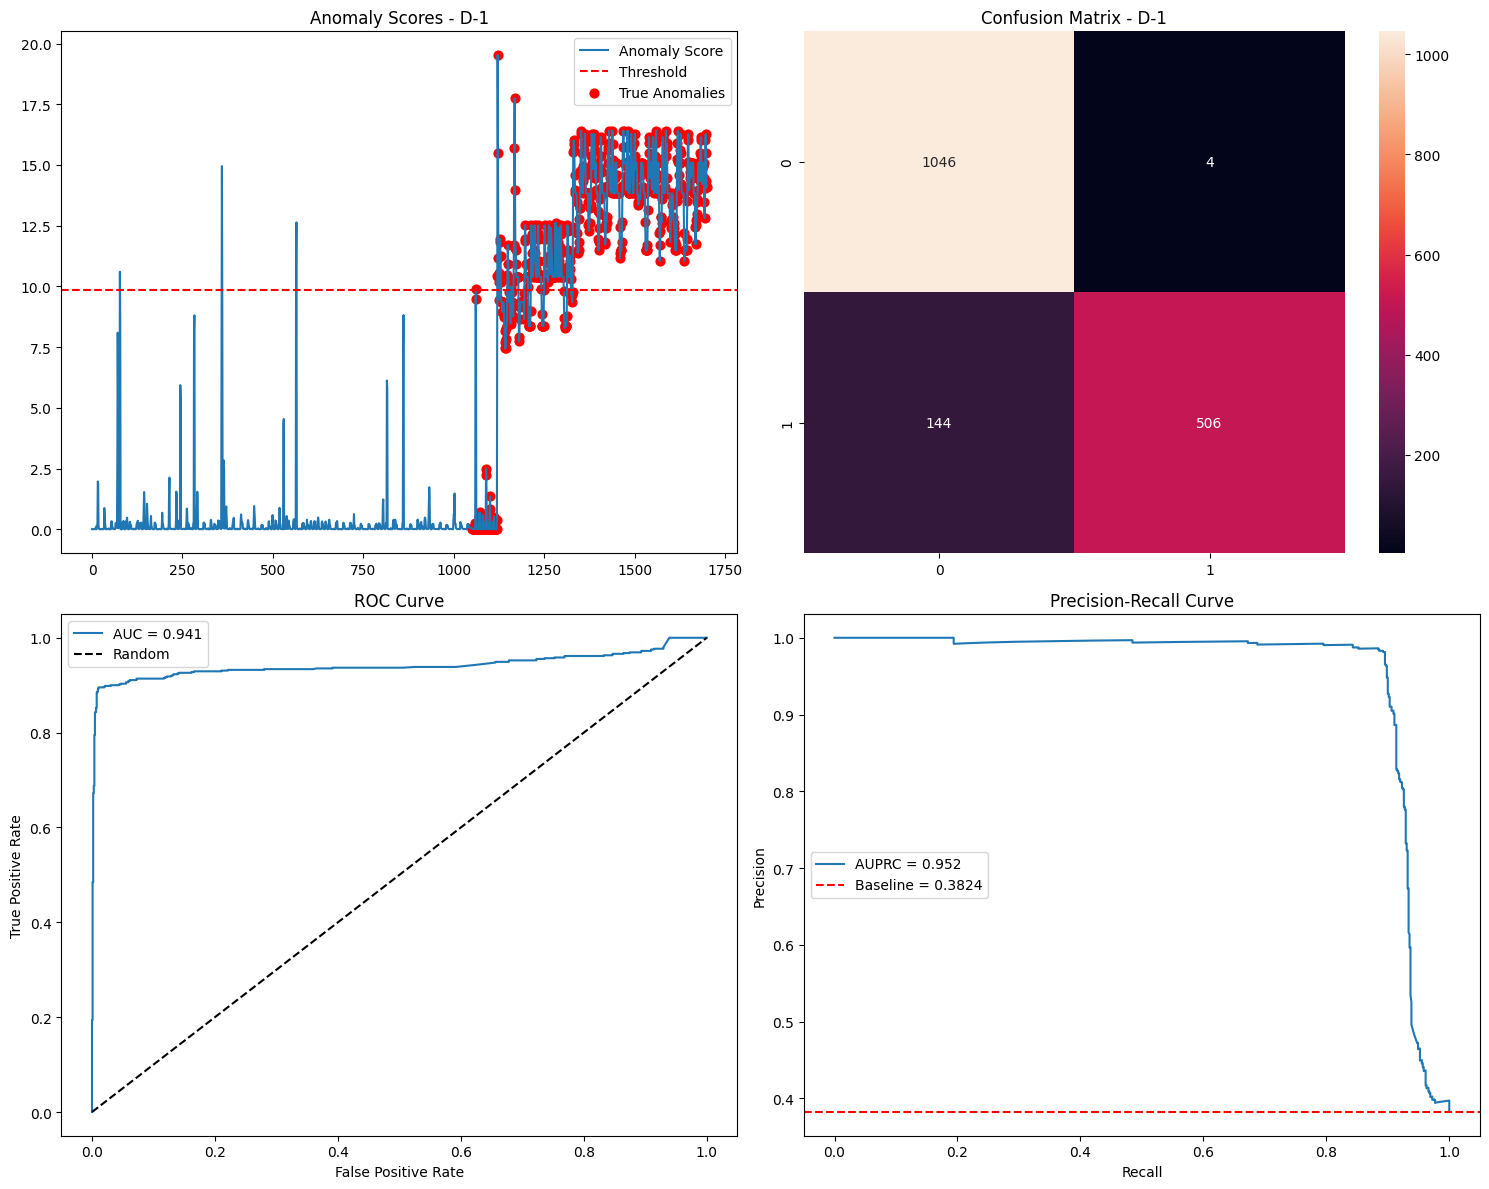


Metrics:
Accuracy: 0.913
Precision: 0.992
Recall: 0.778
F1: 0.872
AUROC: 0.941
AUPRC: 0.952 (Baseline: 0.3824)

Processing channel D-11
Channel D-11:
Total windows: 1485
Anomaly windows: 13
Anomaly class: 40    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-11 Insufficient anomaly windows

Processing channel D-12
Channel D-12:
Total windows: 1582
Anomaly windows: 547
Anomaly class: 41    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.0063, Val Loss: 0.0043
Epoch 2, Train Loss: 0.0038, Val Loss: 0.0025
Epoch 3, Train Loss: 0.0022, Val Loss: 0.0014
Epoch 4, Train Loss: 0.0012, Val Loss: 0.0008
Epoch 5, Train Loss: 0.0007, Val Loss: 0.0005
Epoch 6, Train Loss: 0.0005, Val Loss: 0.0004
Epoch 7, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 8, Train Loss: 0.0003, Val Loss: 0.0002
Epoch 9, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 10, Train Loss: 0.0002, Val Loss: 0.0001
Epoch 11, Train Loss: 0.0001, Val Loss: 0.0001
Epoch 12, Train Loss: 0.0001, Val Loss: 0.000

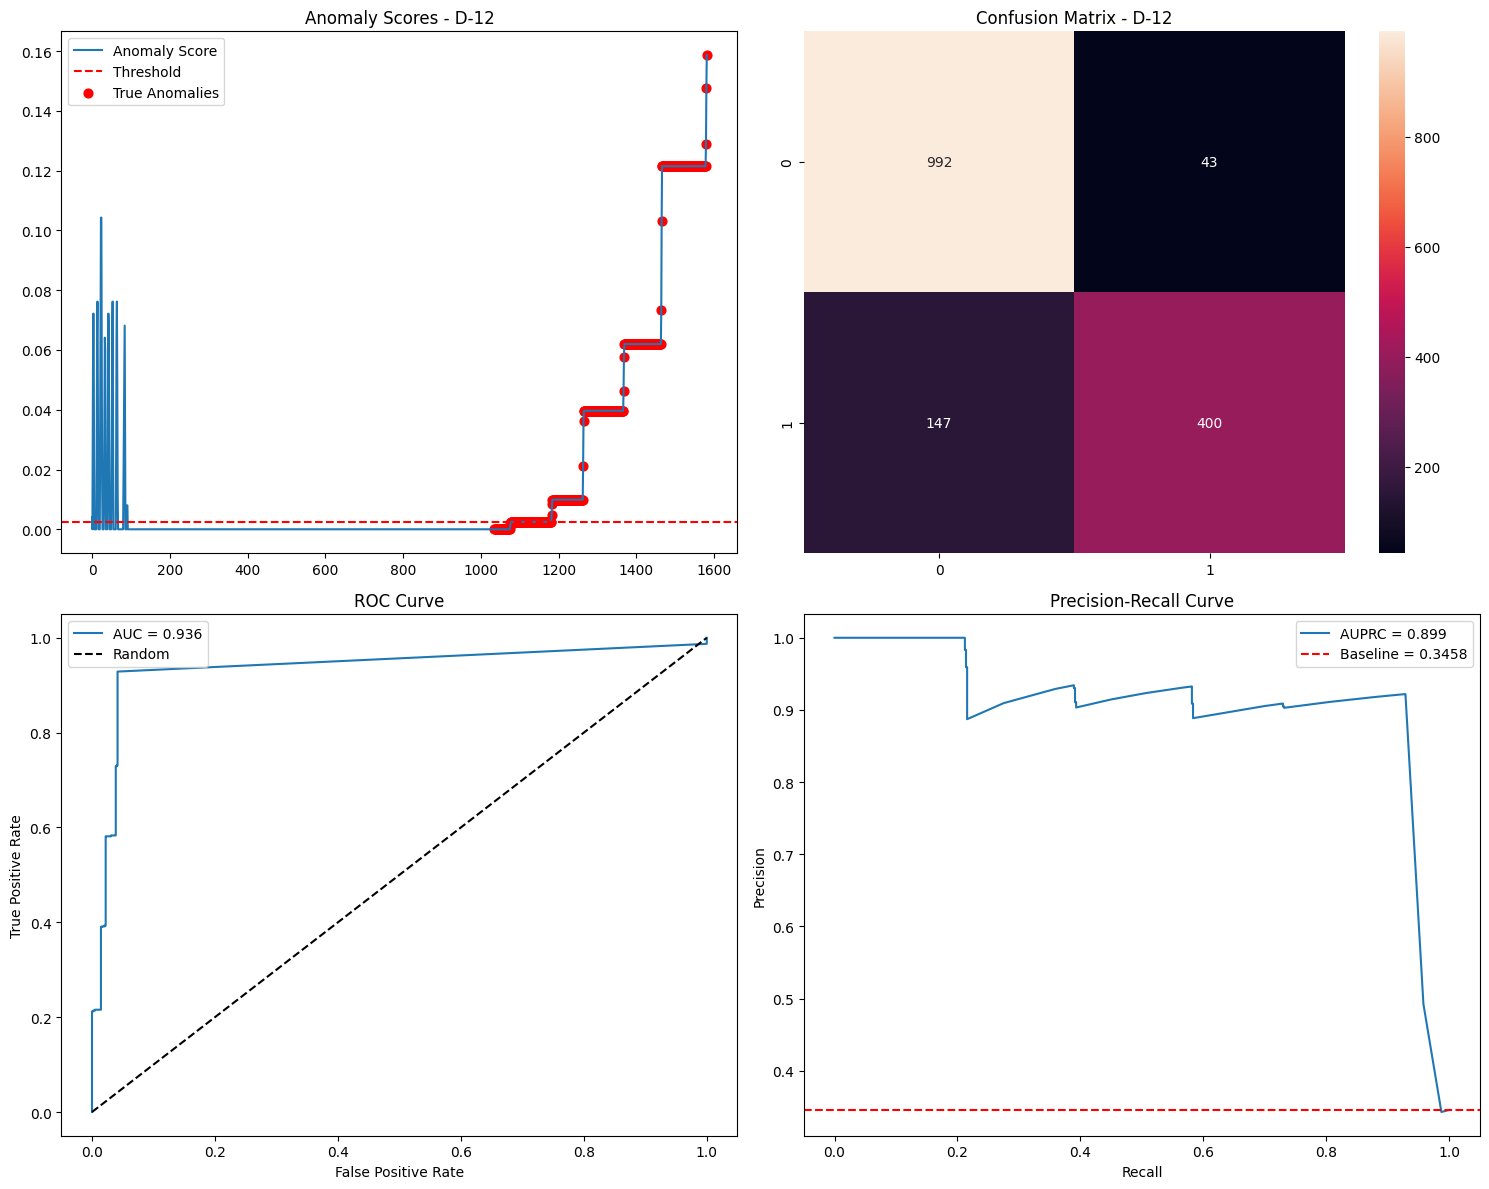


Metrics:
Accuracy: 0.880
Precision: 0.903
Recall: 0.731
F1: 0.808
AUROC: 0.936
AUPRC: 0.899 (Baseline: 0.3458)

Processing channel D-13
Channel D-13:
Total windows: 1531
Anomaly windows: 33
Anomaly class: 50    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-13 Insufficient anomaly windows

Processing channel D-14
Channel D-14:
Total windows: 524
Anomaly windows: 46
Anomaly class: 73    [point, point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-14 Insufficient anomaly windows

Processing channel D-15
Channel D-15:
Total windows: 430
Anomaly windows: 129
Anomaly class: 78    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.2502, Val Loss: 0.2322
Epoch 2, Train Loss: 0.2531, Val Loss: 0.2297
Epoch 3, Train Loss: 0.2410, Val Loss: 0.2259
Epoch 4, Train Loss: 0.2688, Val Loss: 0.2230
Epoch 5, Train Loss: 0.2324, Val Loss: 0.2208
Epoch 6, Train Loss: 0.2396, Val Loss: 0.2197
Epoch 7, Train Loss: 0.2356, Val Loss: 0.2187
Epoch 8, Train Loss: 0.2381

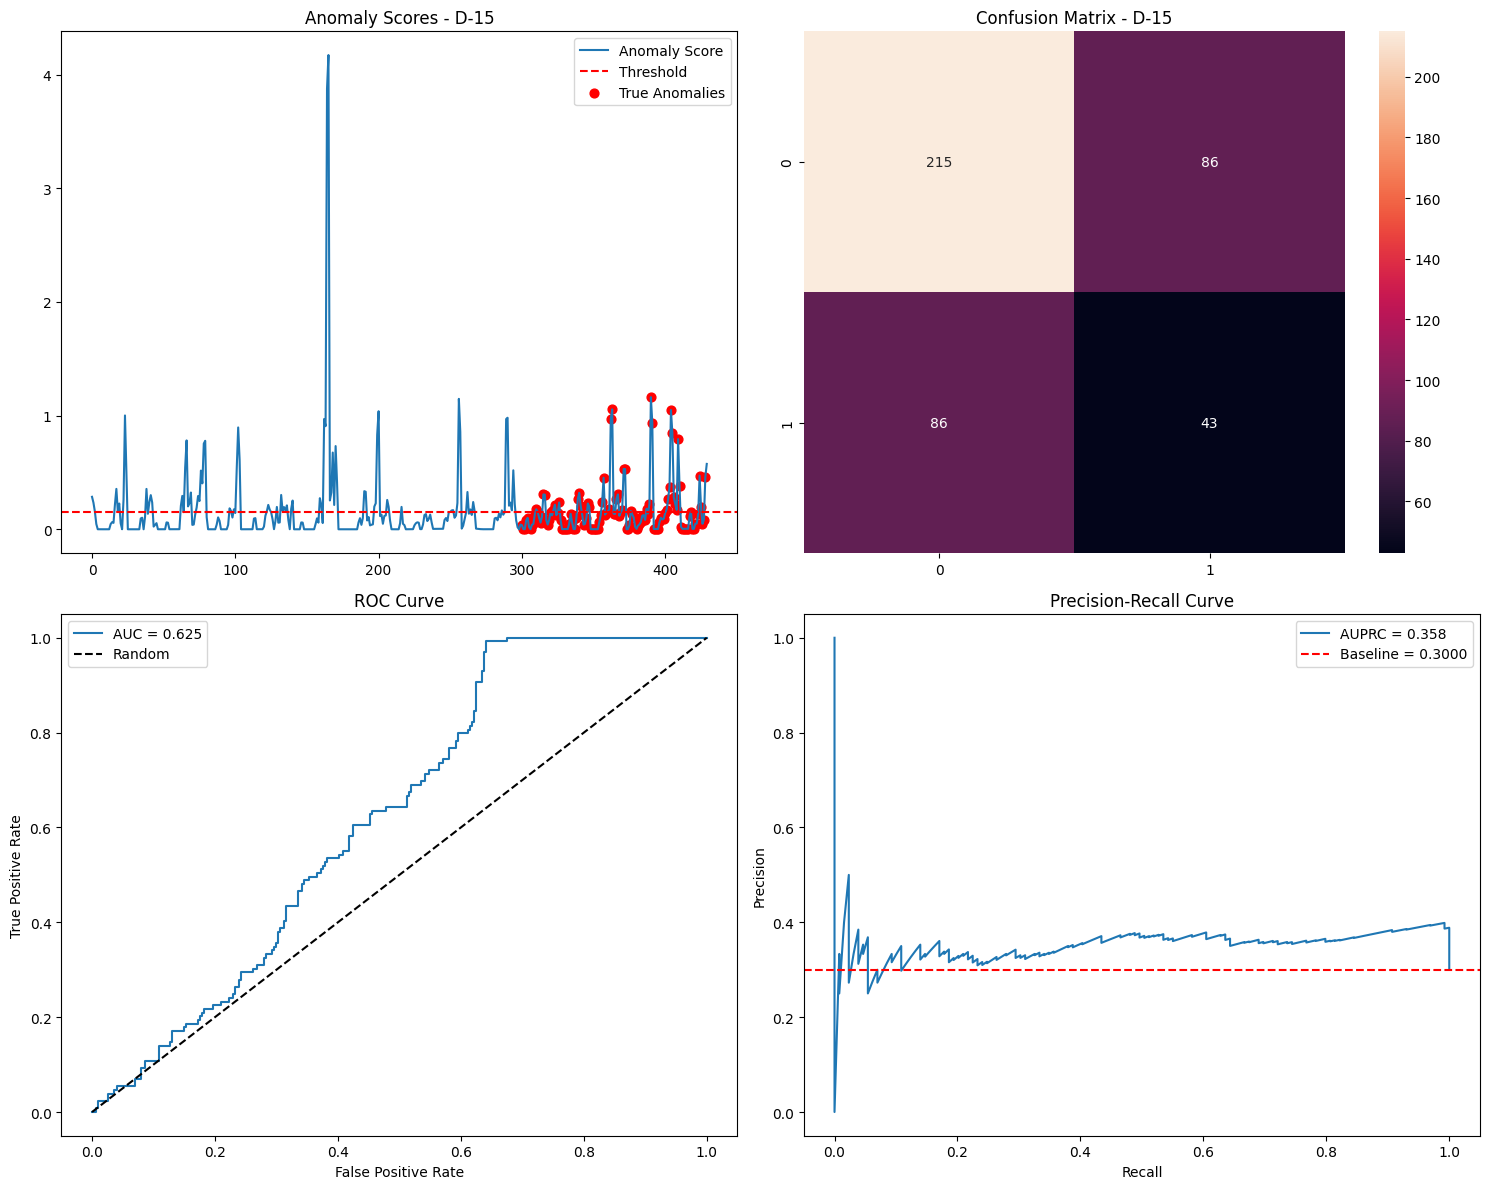


Metrics:
Accuracy: 0.600
Precision: 0.333
Recall: 0.333
F1: 0.333
AUROC: 0.625
AUPRC: 0.358 (Baseline: 0.3000)

Processing channel D-16
Channel D-16:
Total windows: 437
Anomaly windows: 131
Anomaly class: 79    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.2606, Val Loss: 0.2649
Epoch 2, Train Loss: 0.2545, Val Loss: 0.2632
Epoch 3, Train Loss: 0.2542, Val Loss: 0.2602
Epoch 4, Train Loss: 0.2373, Val Loss: 0.2571
Epoch 5, Train Loss: 0.2477, Val Loss: 0.2545
Epoch 6, Train Loss: 0.2398, Val Loss: 0.2527
Epoch 7, Train Loss: 0.2446, Val Loss: 0.2516
Epoch 8, Train Loss: 0.2736, Val Loss: 0.2505
Epoch 9, Train Loss: 0.2320, Val Loss: 0.2494
Epoch 10, Train Loss: 0.2276, Val Loss: 0.2484
Epoch 11, Train Loss: 0.2560, Val Loss: 0.2475
Epoch 12, Train Loss: 0.2359, Val Loss: 0.2469
Epoch 13, Train Loss: 0.2433, Val Loss: 0.2458
Epoch 14, Train Loss: 0.2293, Val Loss: 0.2455
Epoch 15, Train Loss: 0.2240, Val Loss: 0.2446
Epoch 16, Train Loss: 0.2228, Val Loss: 0.2439
Epoch

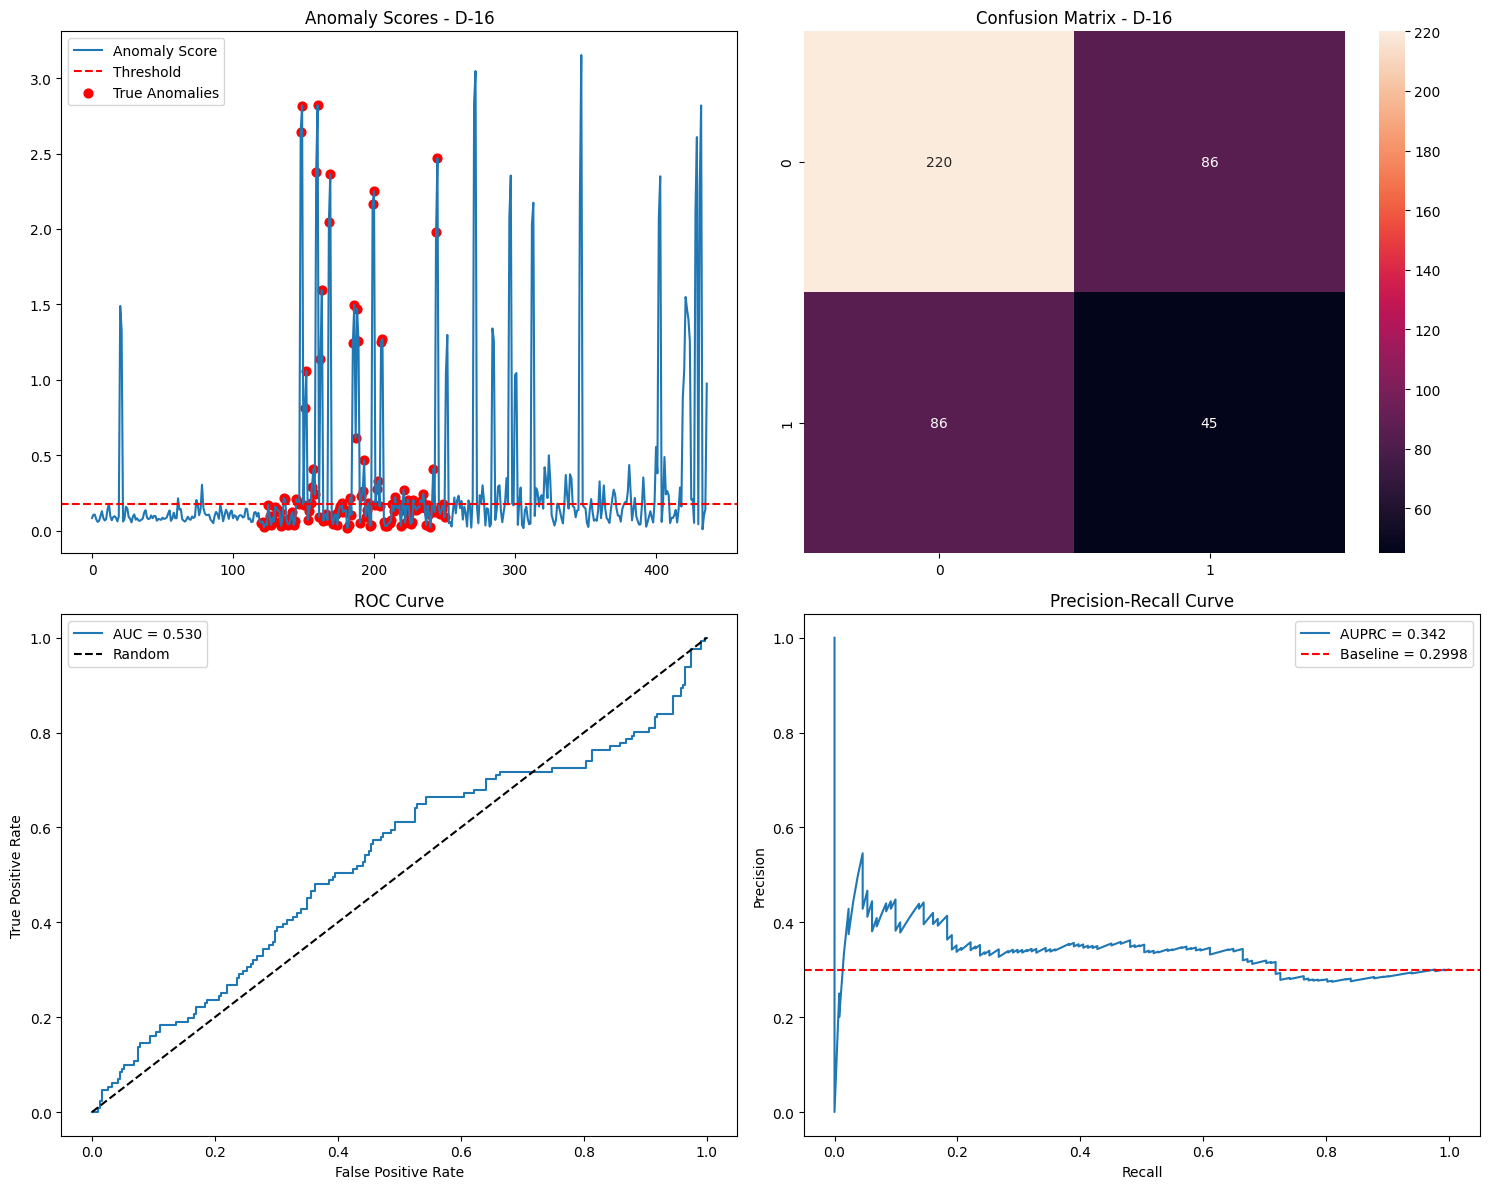


Metrics:
Accuracy: 0.606
Precision: 0.344
Recall: 0.344
F1: 0.344
AUROC: 0.530
AUPRC: 0.342 (Baseline: 0.2998)

Processing channel D-2
Channel D-2:
Total windows: 1718
Anomaly windows: 845
Anomaly class: 19    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7432, Val Loss: 0.6616
Epoch 2, Train Loss: 0.7030, Val Loss: 0.6321
Epoch 3, Train Loss: 0.6703, Val Loss: 0.6158
Epoch 4, Train Loss: 0.6650, Val Loss: 0.6115
Epoch 5, Train Loss: 0.7422, Val Loss: 0.6028
Epoch 6, Train Loss: 0.6394, Val Loss: 0.5951
Epoch 7, Train Loss: 0.6428, Val Loss: 0.5885
Epoch 8, Train Loss: 0.6264, Val Loss: 0.5779
Epoch 9, Train Loss: 0.6472, Val Loss: 0.5729
Epoch 10, Train Loss: 0.6194, Val Loss: 0.5604
Epoch 11, Train Loss: 0.6082, Val Loss: 0.5556
Epoch 12, Train Loss: 0.5949, Val Loss: 0.5533
Epoch 13, Train Loss: 0.5996, Val Loss: 0.5461
Epoch 14, Train Loss: 0.5805, Val Loss: 0.5420
Epoch 15, Train Loss: 0.6509, Val Loss: 0.5392
Epoch 16, Train Loss: 0.5780, Val Loss: 0.5376
Epoch 17, T

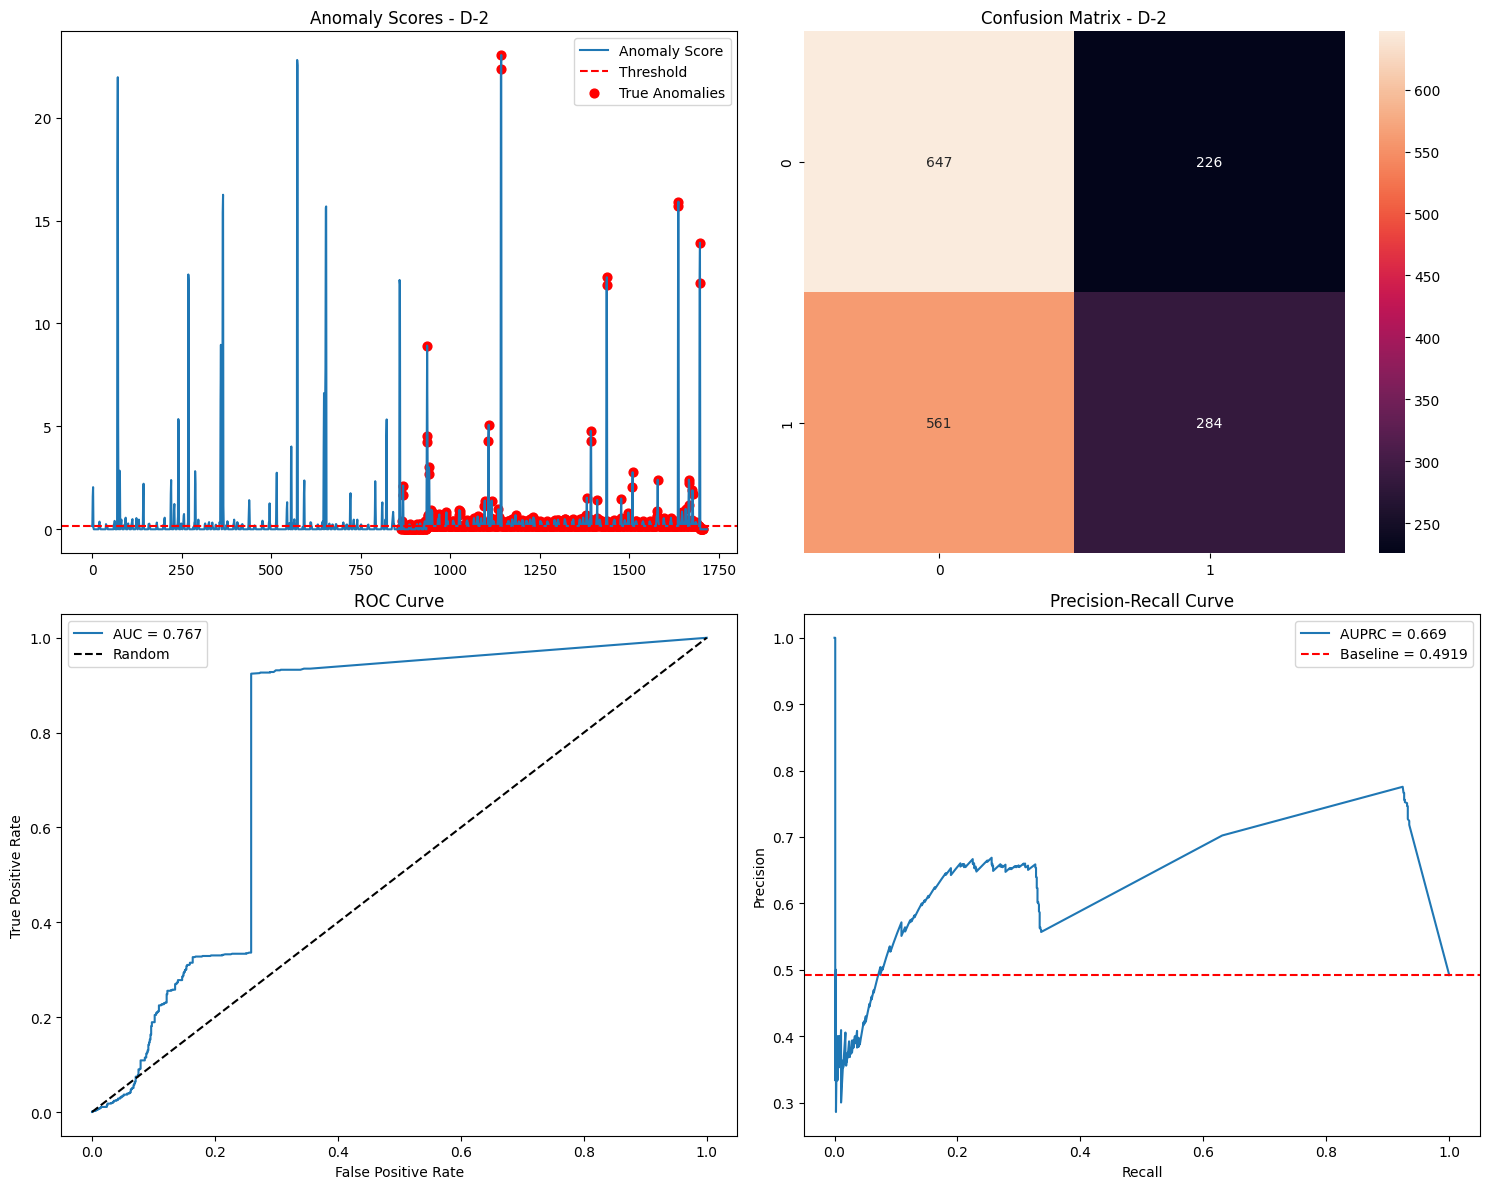


Metrics:
Accuracy: 0.542
Precision: 0.557
Recall: 0.336
F1: 0.419
AUROC: 0.767
AUPRC: 0.669 (Baseline: 0.4919)

Processing channel D-3
Channel D-3:
Total windows: 1727
Anomaly windows: 656
Anomaly class: 20    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7372, Val Loss: 0.6843
Epoch 2, Train Loss: 0.7084, Val Loss: 0.6464
Epoch 3, Train Loss: 0.7238, Val Loss: 0.6221
Epoch 4, Train Loss: 0.6610, Val Loss: 0.6087
Epoch 5, Train Loss: 0.6663, Val Loss: 0.6010
Epoch 6, Train Loss: 0.6500, Val Loss: 0.5936
Epoch 7, Train Loss: 0.7175, Val Loss: 0.5865
Epoch 8, Train Loss: 0.6371, Val Loss: 0.5791
Epoch 9, Train Loss: 0.6807, Val Loss: 0.5699
Epoch 10, Train Loss: 0.6124, Val Loss: 0.5645
Epoch 11, Train Loss: 0.5974, Val Loss: 0.5567
Epoch 12, Train Loss: 0.6124, Val Loss: 0.5496
Epoch 13, Train Loss: 0.5923, Val Loss: 0.5429
Epoch 14, Train Loss: 0.6185, Val Loss: 0.5390
Epoch 15, Train Loss: 0.6212, Val Loss: 0.5325
Epoch 16, Train Loss: 0.5823, Val Loss: 0.5277
Epoch 17, T

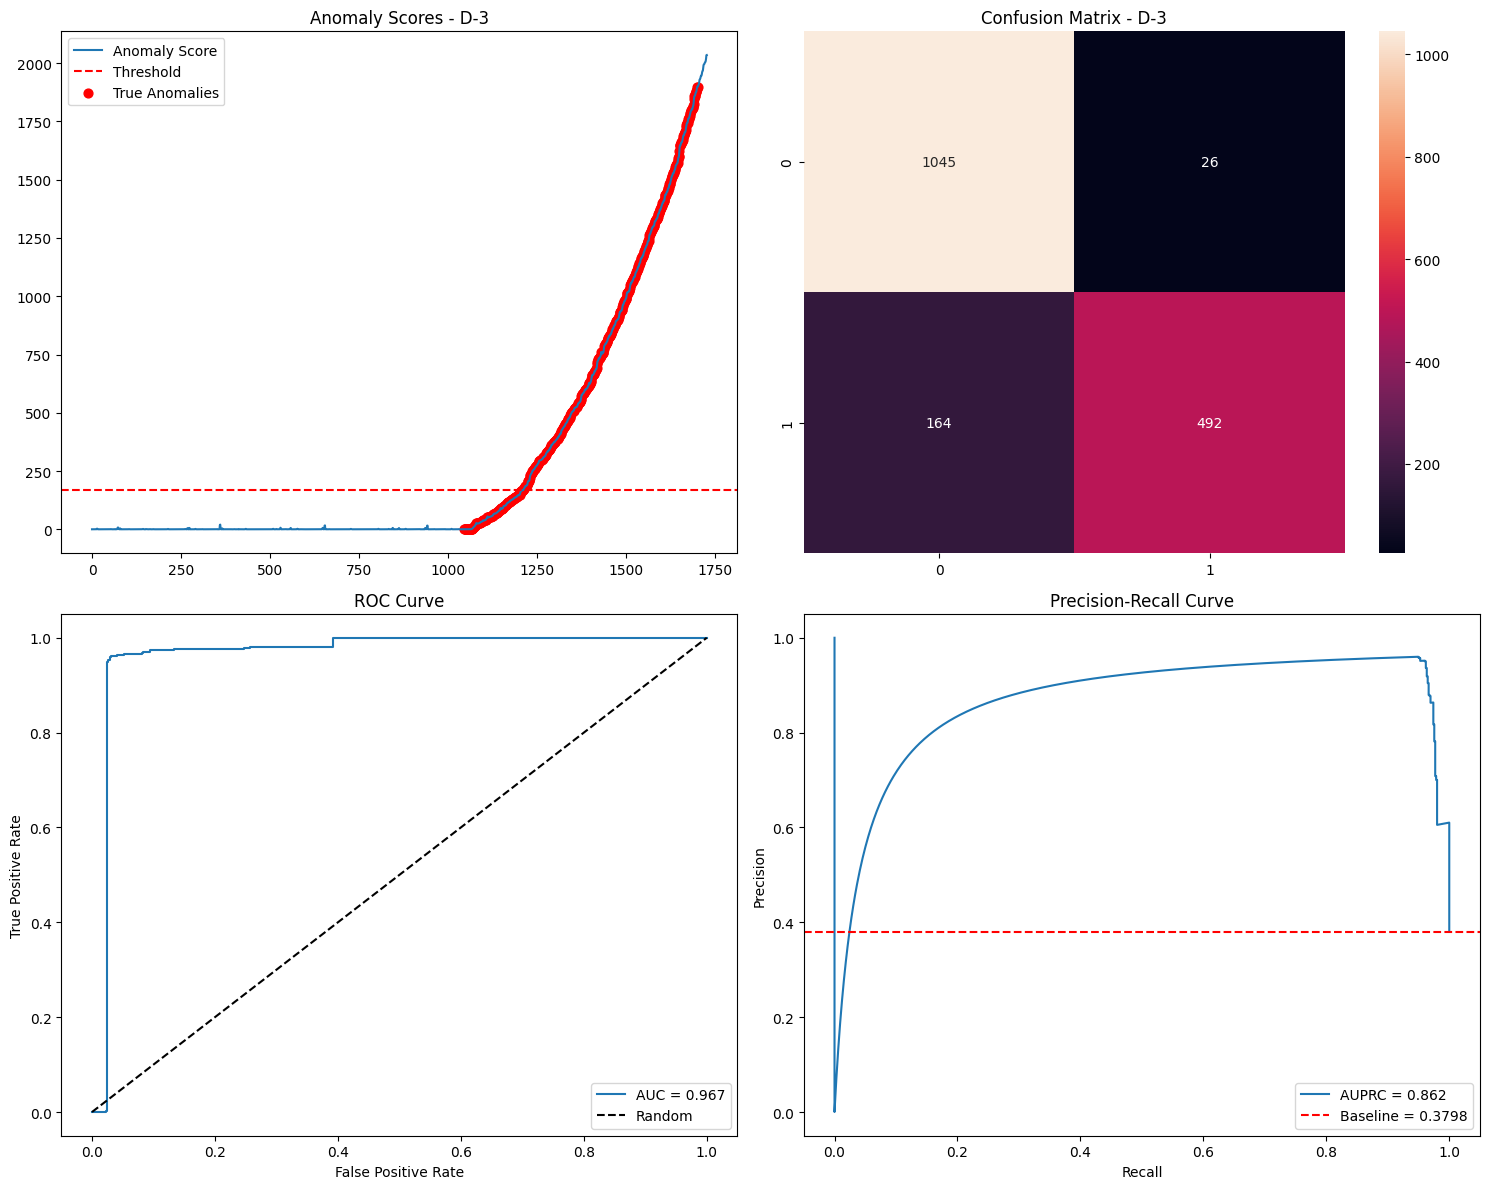


Metrics:
Accuracy: 0.890
Precision: 0.950
Recall: 0.750
F1: 0.838
AUROC: 0.967
AUPRC: 0.862 (Baseline: 0.3798)

Processing channel D-4
Channel D-4:
Total windows: 1693
Anomaly windows: 648
Anomaly class: 21    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7184, Val Loss: 0.7297
Epoch 2, Train Loss: 0.6828, Val Loss: 0.6839
Epoch 3, Train Loss: 0.6397, Val Loss: 0.6582
Epoch 4, Train Loss: 0.6301, Val Loss: 0.6441
Epoch 5, Train Loss: 0.6612, Val Loss: 0.6360
Epoch 6, Train Loss: 0.5994, Val Loss: 0.6310
Epoch 7, Train Loss: 0.6020, Val Loss: 0.6256
Epoch 8, Train Loss: 0.6030, Val Loss: 0.6191
Epoch 9, Train Loss: 0.6428, Val Loss: 0.6131
Epoch 10, Train Loss: 0.5746, Val Loss: 0.6147
Epoch 11, Train Loss: 0.5704, Val Loss: 0.6053
Epoch 12, Train Loss: 0.5801, Val Loss: 0.6004
Epoch 13, Train Loss: 0.5648, Val Loss: 0.5957
Epoch 14, Train Loss: 0.5607, Val Loss: 0.5992
Epoch 15, Train Loss: 0.7165, Val Loss: 0.5880
Epoch 16, Train Loss: 0.5675, Val Loss: 0.5963
Epoch 17, T

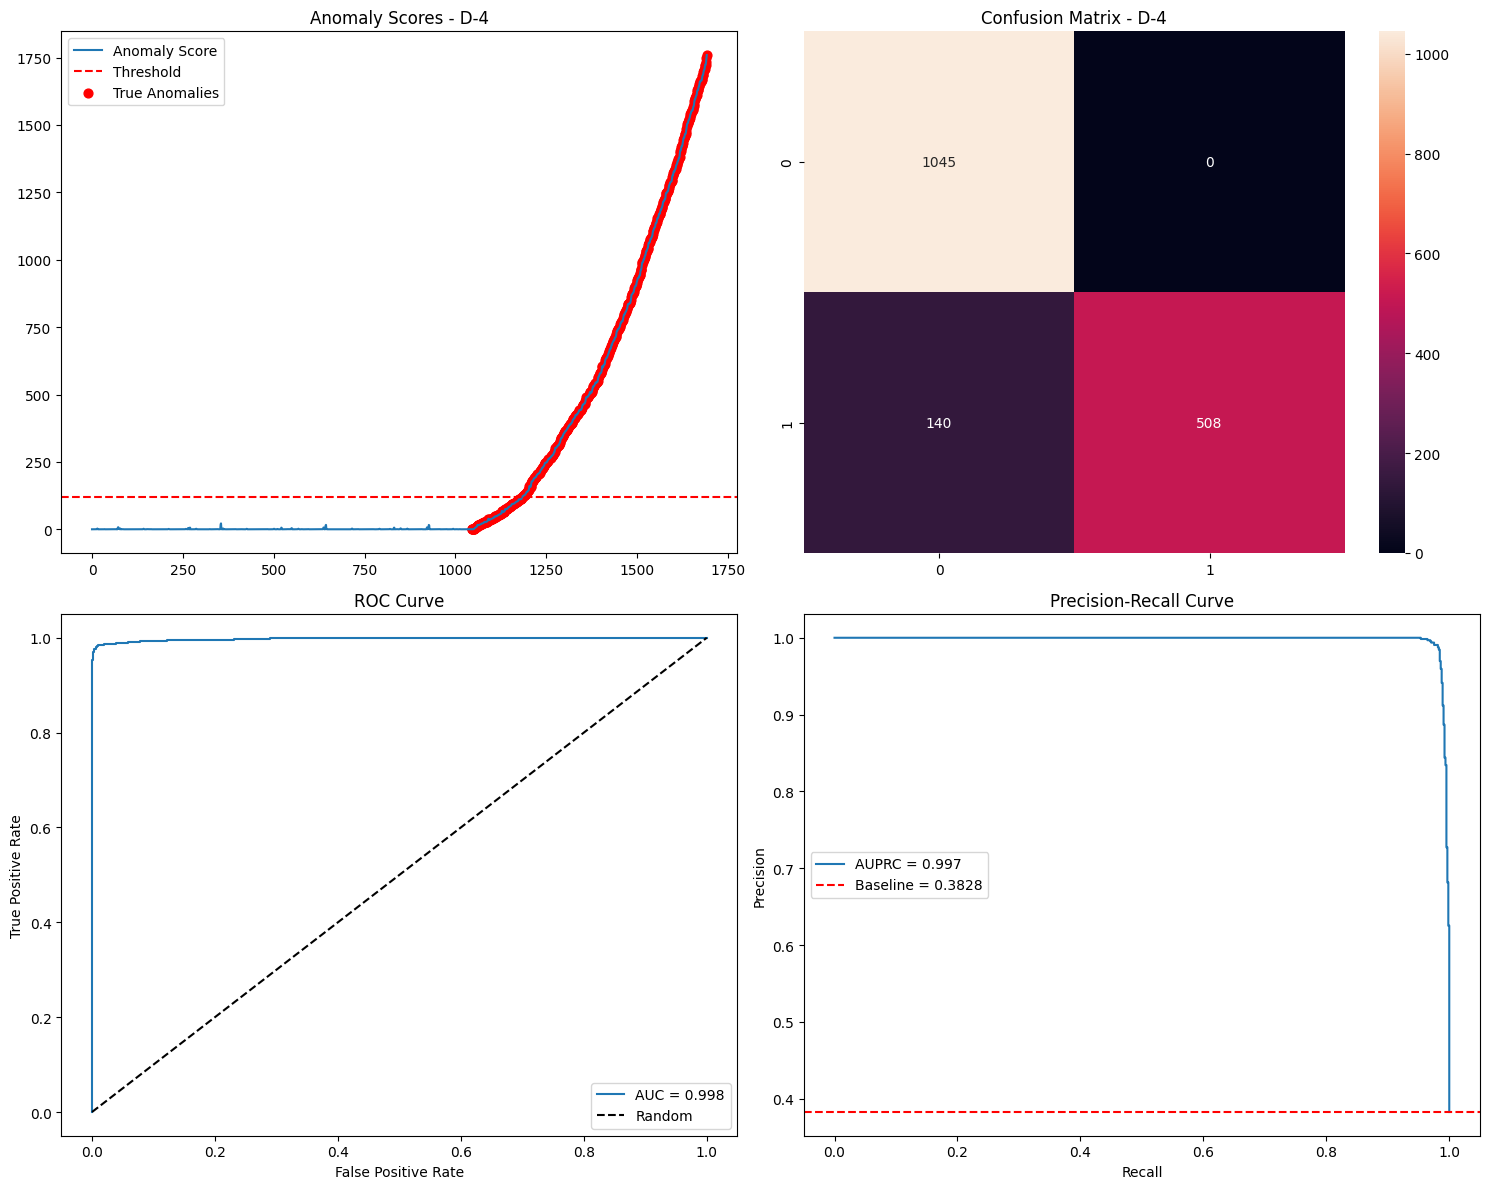


Metrics:
Accuracy: 0.917
Precision: 1.000
Recall: 0.784
F1: 0.879
AUROC: 0.998
AUPRC: 0.997 (Baseline: 0.3828)

Processing channel D-5
Channel D-5:
Total windows: 1524
Anomaly windows: 11
Anomaly class: 27    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-5 Insufficient anomaly windows

Processing channel D-6
Channel D-6:
Total windows: 1575
Anomaly windows: 17
Anomaly class: 28    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-6 Insufficient anomaly windows

Processing channel D-7
Channel D-7:
Total windows: 1527
Anomaly windows: 539
Anomaly class: 29    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7683, Val Loss: 0.4494
Epoch 2, Train Loss: 0.7295, Val Loss: 0.4196
Epoch 3, Train Loss: 0.7068, Val Loss: 0.4113
Epoch 4, Train Loss: 0.7096, Val Loss: 0.4065
Epoch 5, Train Loss: 0.6969, Val Loss: 0.4014
Epoch 6, Train Loss: 0.6885, Val Loss: 0.3973
Epoch 7, Train Loss: 0.6798, Val Loss: 0.3906
Epoch 8, Train Loss: 0.6749, Val Loss: 0

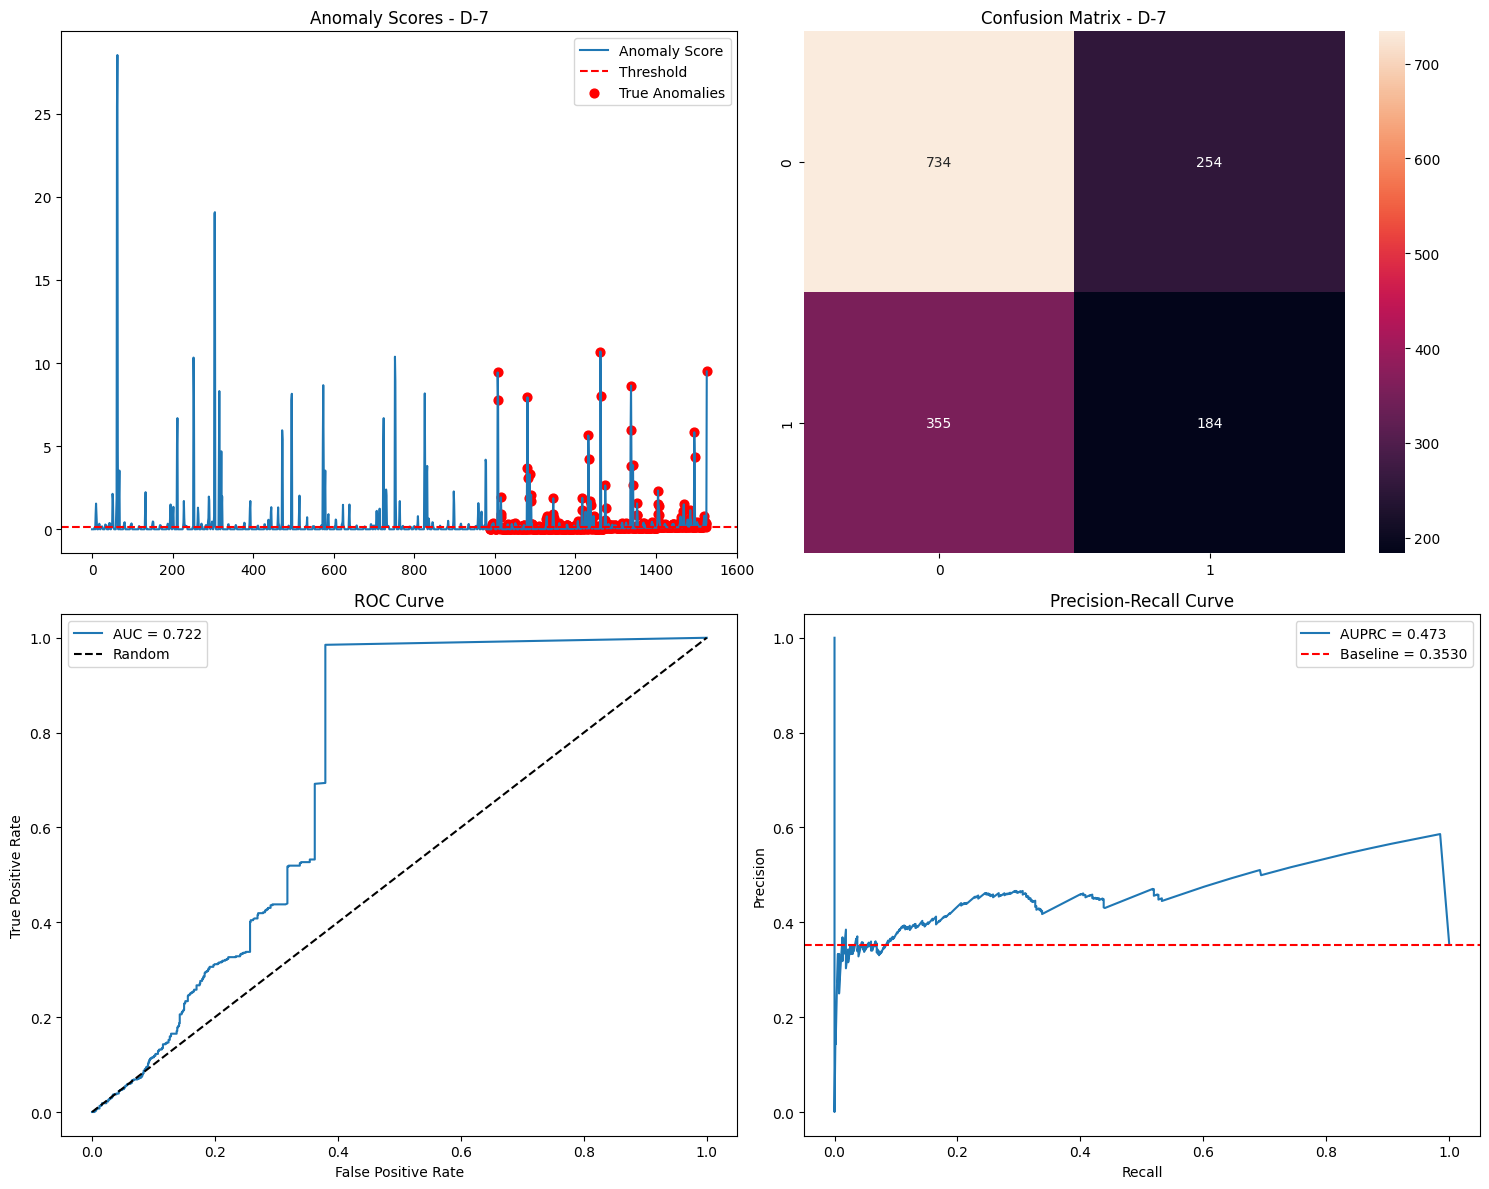


Metrics:
Accuracy: 0.601
Precision: 0.420
Recall: 0.341
F1: 0.377
AUROC: 0.722
AUPRC: 0.473 (Baseline: 0.3530)

Processing channel D-8
Channel D-8:
Total windows: 1573
Anomaly windows: 11
Anomaly class: 35    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel D-8 Insufficient anomaly windows

Processing channel D-9
Channel D-9:
Total windows: 1480
Anomaly windows: 230
Anomaly class: 36    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.4906, Val Loss: 0.7487
Epoch 2, Train Loss: 0.4624, Val Loss: 0.6977
Epoch 3, Train Loss: 0.4460, Val Loss: 0.6507
Epoch 4, Train Loss: 0.4310, Val Loss: 0.6183
Epoch 5, Train Loss: 0.4354, Val Loss: 0.6004
Epoch 6, Train Loss: 0.4221, Val Loss: 0.5930
Epoch 7, Train Loss: 0.4158, Val Loss: 0.5883
Epoch 8, Train Loss: 0.4186, Val Loss: 0.5832
Epoch 9, Train Loss: 0.4111, Val Loss: 0.5752
Epoch 10, Train Loss: 0.4193, Val Loss: 0.5705
Epoch 11, Train Loss: 0.4034, Val Loss: 0.5668
Epoch 12, Train Loss: 0.4003, Val Loss: 0.5608
Epo

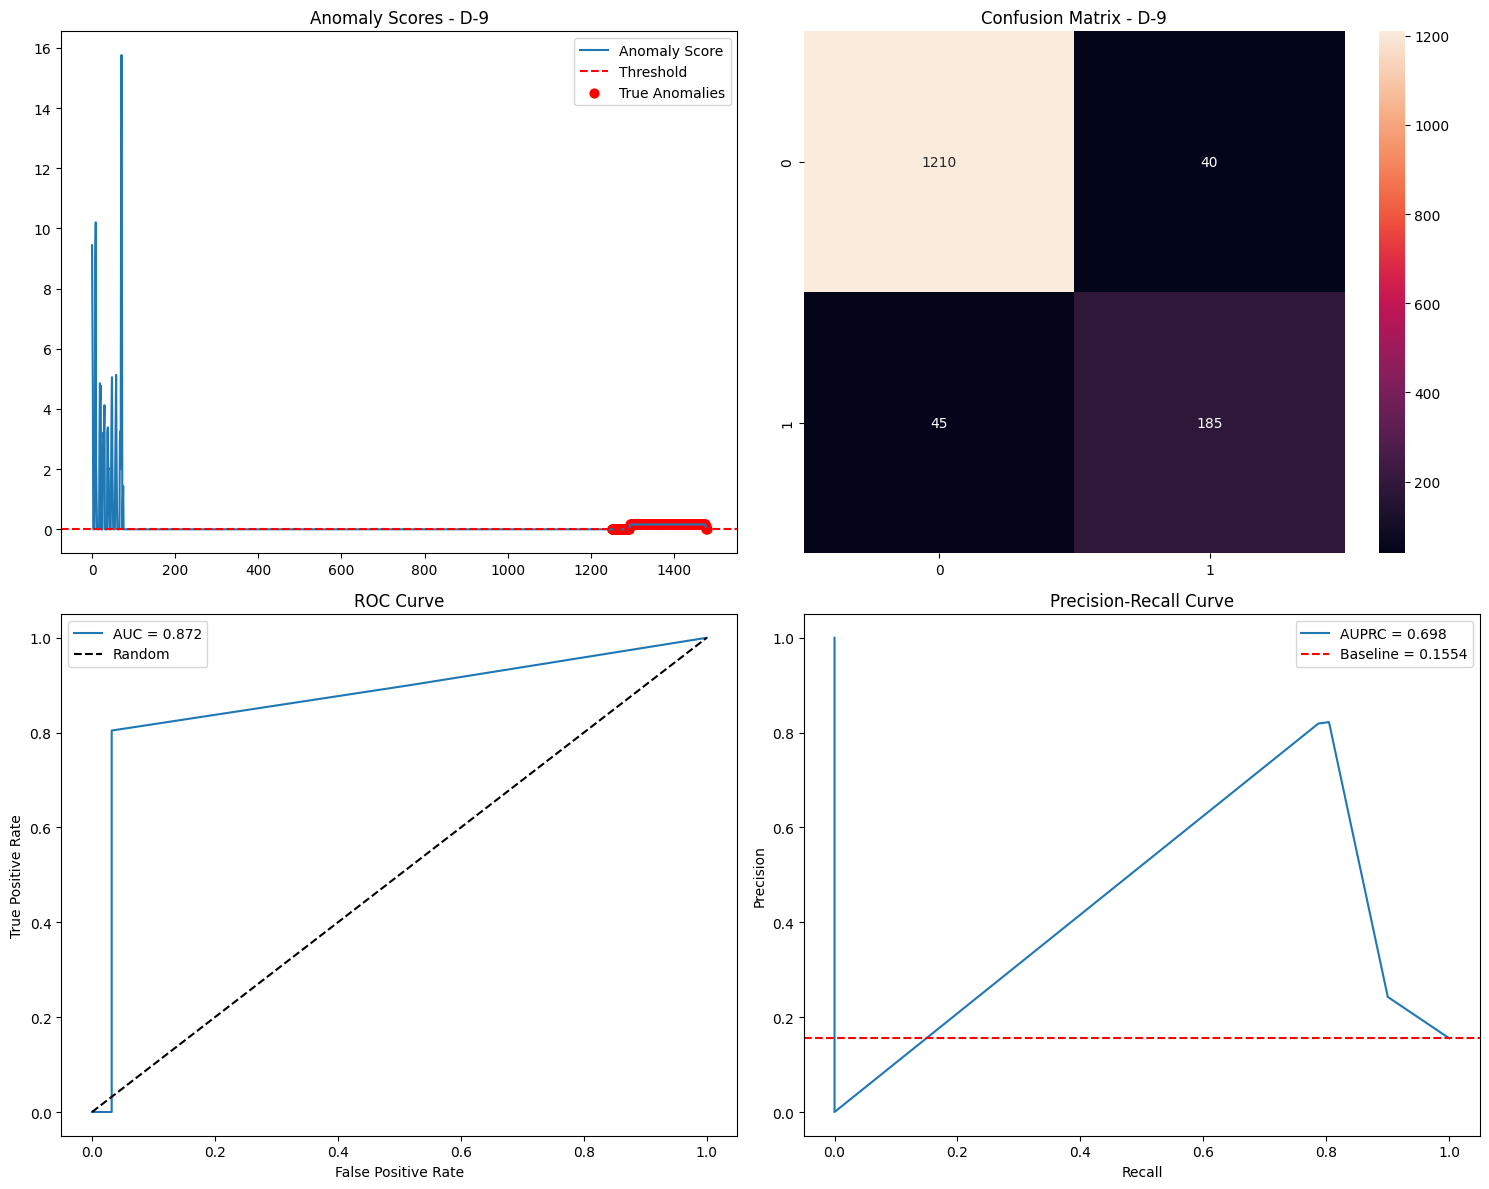


Metrics:
Accuracy: 0.943
Precision: 0.822
Recall: 0.804
F1: 0.813
AUROC: 0.872
AUPRC: 0.698 (Baseline: 0.1554)

Processing channel E-1
Channel E-1:
Total windows: 1702
Anomaly windows: 103
Anomaly class: 2    [contextual, contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7067, Val Loss: 0.5813
Epoch 2, Train Loss: 0.6638, Val Loss: 0.5449
Epoch 3, Train Loss: 0.6807, Val Loss: 0.5308
Epoch 4, Train Loss: 0.6348, Val Loss: 0.5201
Epoch 5, Train Loss: 0.6206, Val Loss: 0.5119
Epoch 6, Train Loss: 0.6111, Val Loss: 0.5031
Epoch 7, Train Loss: 0.6335, Val Loss: 0.4977
Epoch 8, Train Loss: 0.6292, Val Loss: 0.4899
Epoch 9, Train Loss: 0.5924, Val Loss: 0.4832
Epoch 10, Train Loss: 0.5721, Val Loss: 0.4777
Epoch 11, Train Loss: 0.5661, Val Loss: 0.4708
Epoch 12, Train Loss: 0.5615, Val Loss: 0.4720
Epoch 13, Train Loss: 0.5485, Val Loss: 0.4612
Epoch 14, Train Loss: 0.5721, Val Loss: 0.4547
Epoch 15, Train Loss: 0.6316, Val Loss: 0.4576
Epoch 16, Train Loss: 0.5602, Val Loss: 0.

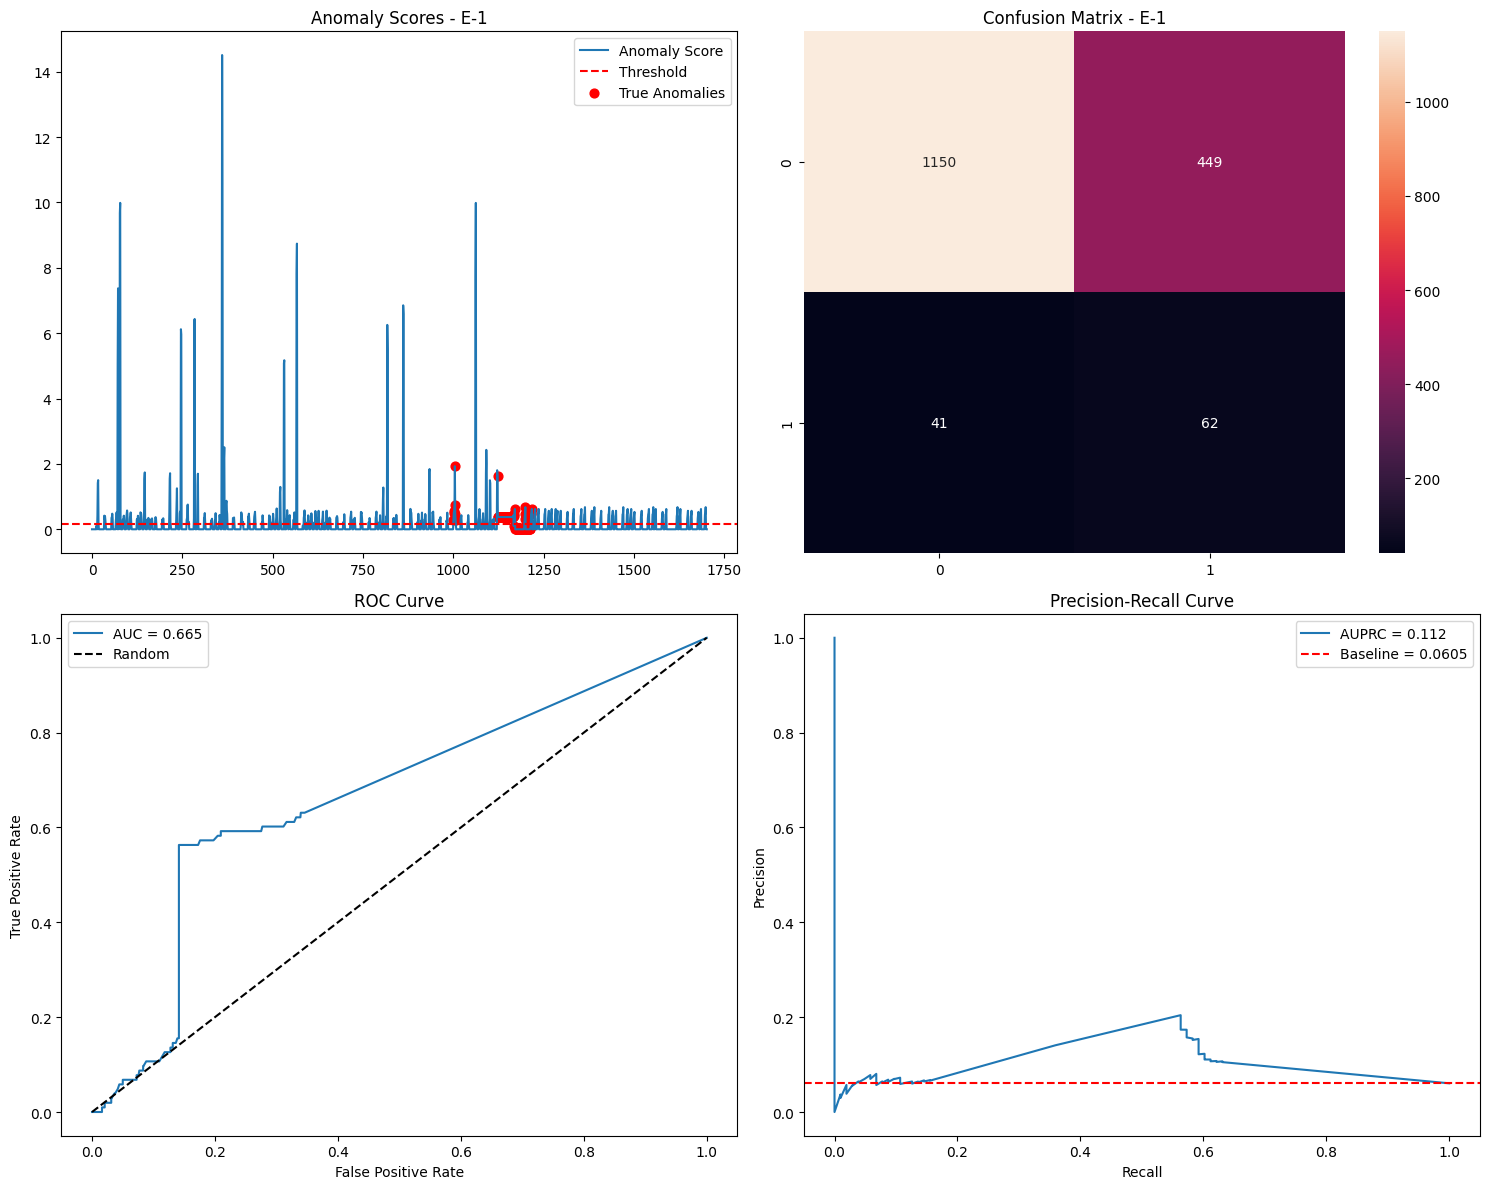


Metrics:
Accuracy: 0.712
Precision: 0.121
Recall: 0.602
F1: 0.202
AUROC: 0.665
AUPRC: 0.112 (Baseline: 0.0605)

Processing channel E-10
Channel E-10:
Total windows: 1700
Anomaly windows: 66
Anomaly class: 11    [contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-10 Insufficient anomaly windows

Processing channel E-11
Channel E-11:
Total windows: 1701
Anomaly windows: 61
Anomaly class: 12    [contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-11 Insufficient anomaly windows

Processing channel E-12
Channel E-12:
Total windows: 1701
Anomaly windows: 118
Anomaly class: 13    [contextual, contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.6730, Val Loss: 0.8613
Epoch 2, Train Loss: 0.6904, Val Loss: 0.8123
Epoch 3, Train Loss: 0.6001, Val Loss: 0.7973
Epoch 4, Train Loss: 0.5992, Val Loss: 0.7888
Epoch 5, Train Loss: 0.5837, Val Loss: 0.7792
Epoch 6, Train Loss: 0.5677, Val Loss: 0.7700
Epoch 7, Train Loss: 0.6354

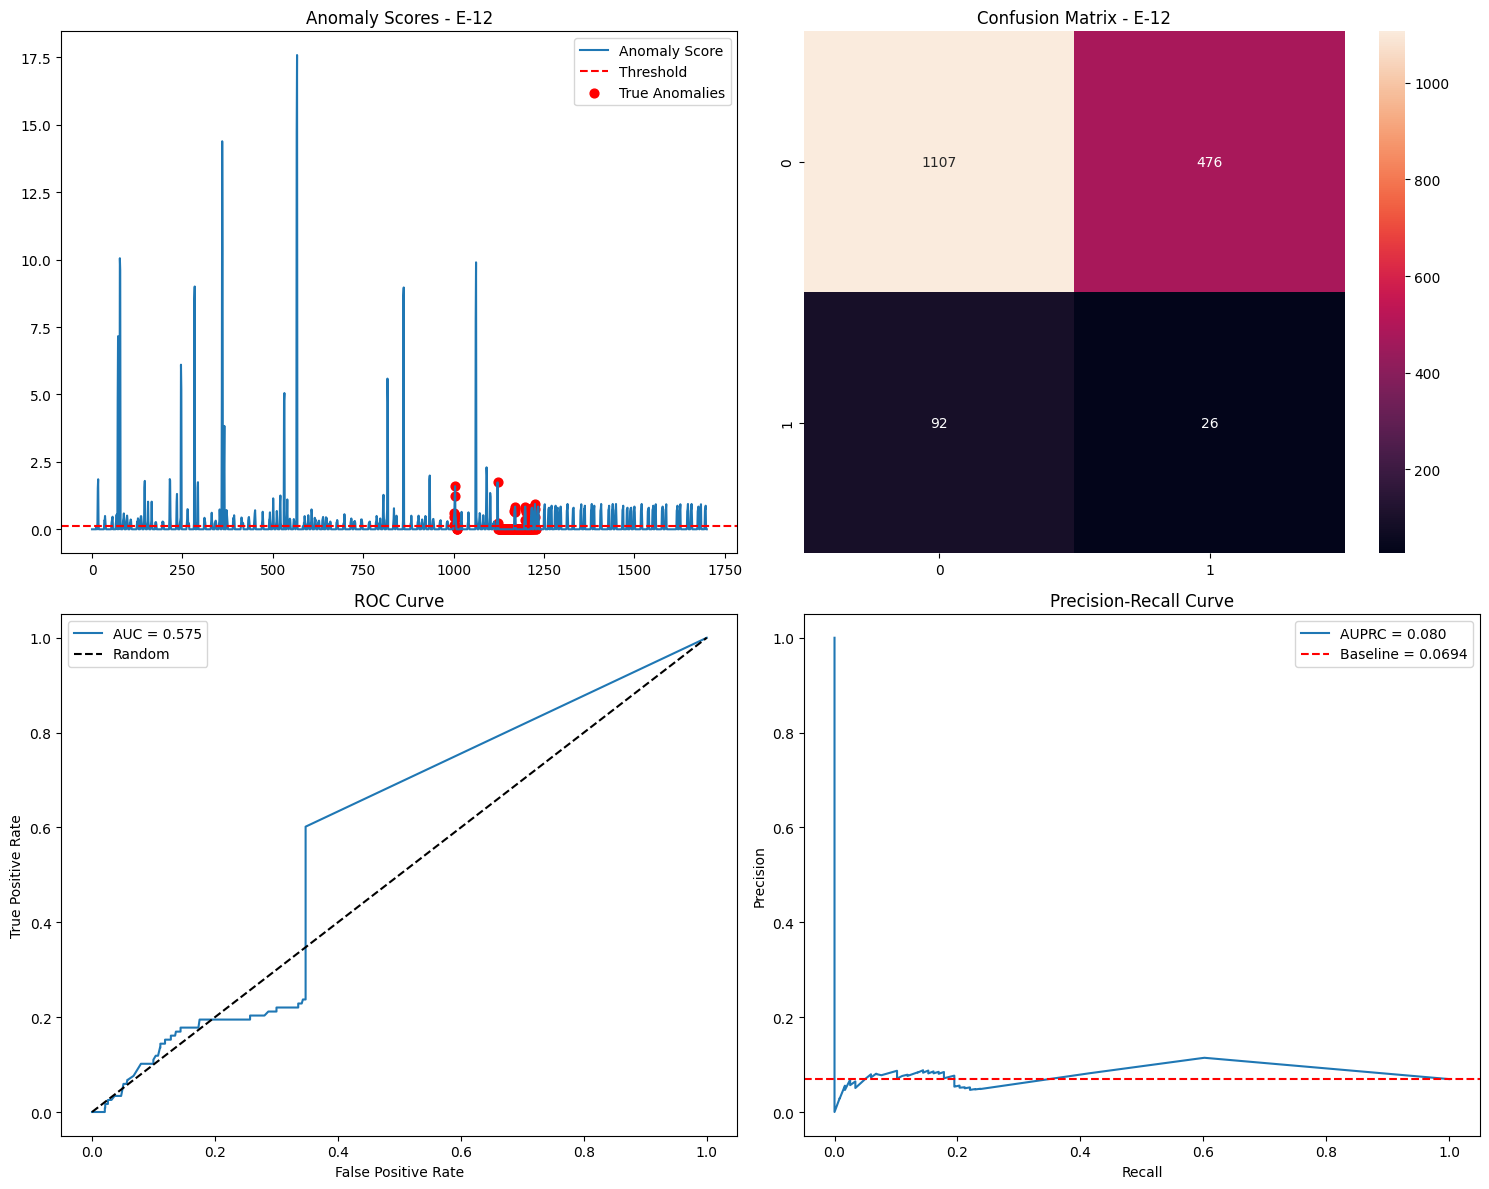


Metrics:
Accuracy: 0.666
Precision: 0.052
Recall: 0.220
F1: 0.084
AUROC: 0.575
AUPRC: 0.080 (Baseline: 0.0694)

Processing channel E-13
Channel E-13:
Total windows: 1727
Anomaly windows: 56
Anomaly class: 14    [contextual, contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-13 Insufficient anomaly windows

Processing channel E-2
Channel E-2:
Total windows: 1705
Anomaly windows: 281
Anomaly class: 3    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7358, Val Loss: 0.5131
Epoch 2, Train Loss: 0.6993, Val Loss: 0.4725
Epoch 3, Train Loss: 0.6677, Val Loss: 0.4630
Epoch 4, Train Loss: 0.6621, Val Loss: 0.4594
Epoch 5, Train Loss: 0.6624, Val Loss: 0.4516
Epoch 6, Train Loss: 0.6730, Val Loss: 0.4426
Epoch 7, Train Loss: 0.6622, Val Loss: 0.4344
Epoch 8, Train Loss: 0.6215, Val Loss: 0.4265
Epoch 9, Train Loss: 0.6077, Val Loss: 0.4189
Epoch 10, Train Loss: 0.6362, Val Loss: 0.4162
Epoch 11, Train Loss: 0.6474, Val Loss: 0.4118
Epoch 12, Train Los

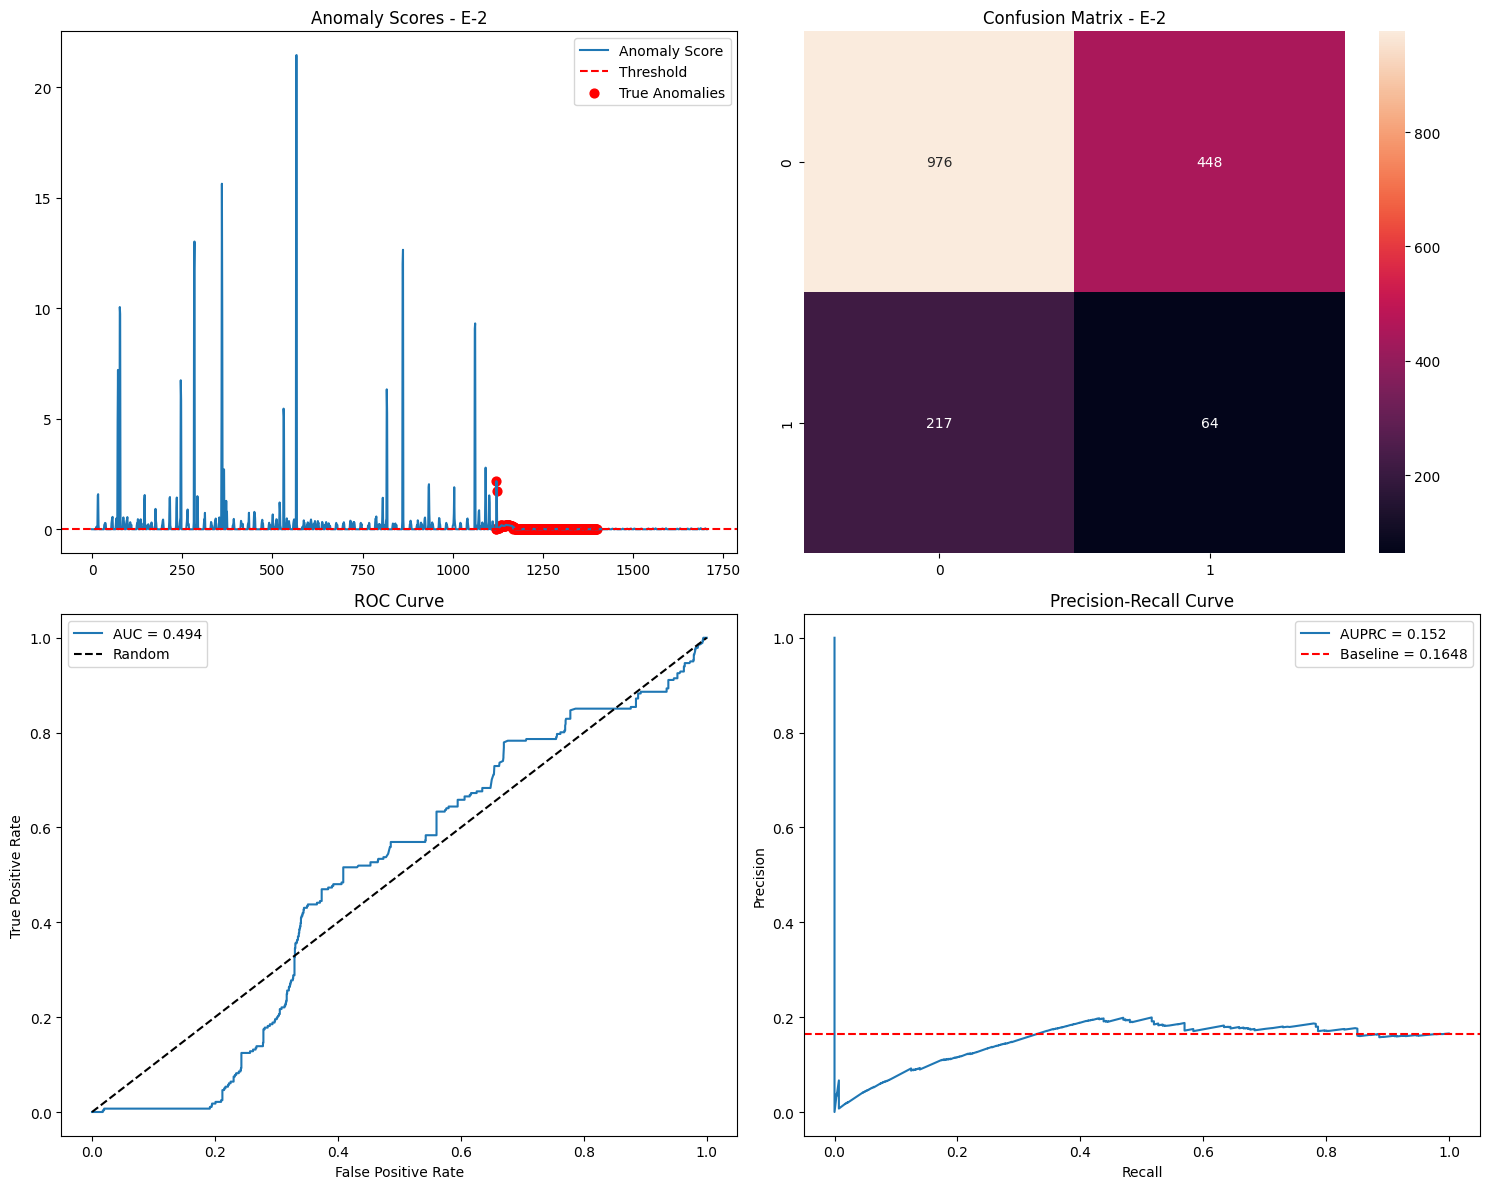


Metrics:
Accuracy: 0.610
Precision: 0.125
Recall: 0.228
F1: 0.161
AUROC: 0.494
AUPRC: 0.152 (Baseline: 0.1648)

Processing channel E-3
Channel E-3:
Total windows: 1660
Anomaly windows: 642
Anomaly class: 4    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7245, Val Loss: 0.5720
Epoch 2, Train Loss: 0.6972, Val Loss: 0.5402
Epoch 3, Train Loss: 0.6617, Val Loss: 0.5171
Epoch 4, Train Loss: 0.6533, Val Loss: 0.5024
Epoch 5, Train Loss: 0.6980, Val Loss: 0.4950
Epoch 6, Train Loss: 0.6432, Val Loss: 0.4914
Epoch 7, Train Loss: 0.6087, Val Loss: 0.4863
Epoch 8, Train Loss: 0.6006, Val Loss: 0.4802
Epoch 9, Train Loss: 0.5961, Val Loss: 0.4749
Epoch 10, Train Loss: 0.6253, Val Loss: 0.4706
Epoch 11, Train Loss: 0.5880, Val Loss: 0.4644
Epoch 12, Train Loss: 0.5688, Val Loss: 0.4620
Epoch 13, Train Loss: 0.5568, Val Loss: 0.4572
Epoch 14, Train Loss: 0.6465, Val Loss: 0.4542
Epoch 15, Train Loss: 0.5527, Val Loss: 0.4490
Epoch 16, Train Loss: 0.5391, Val Loss: 0.4485
Epoch 17, Tr

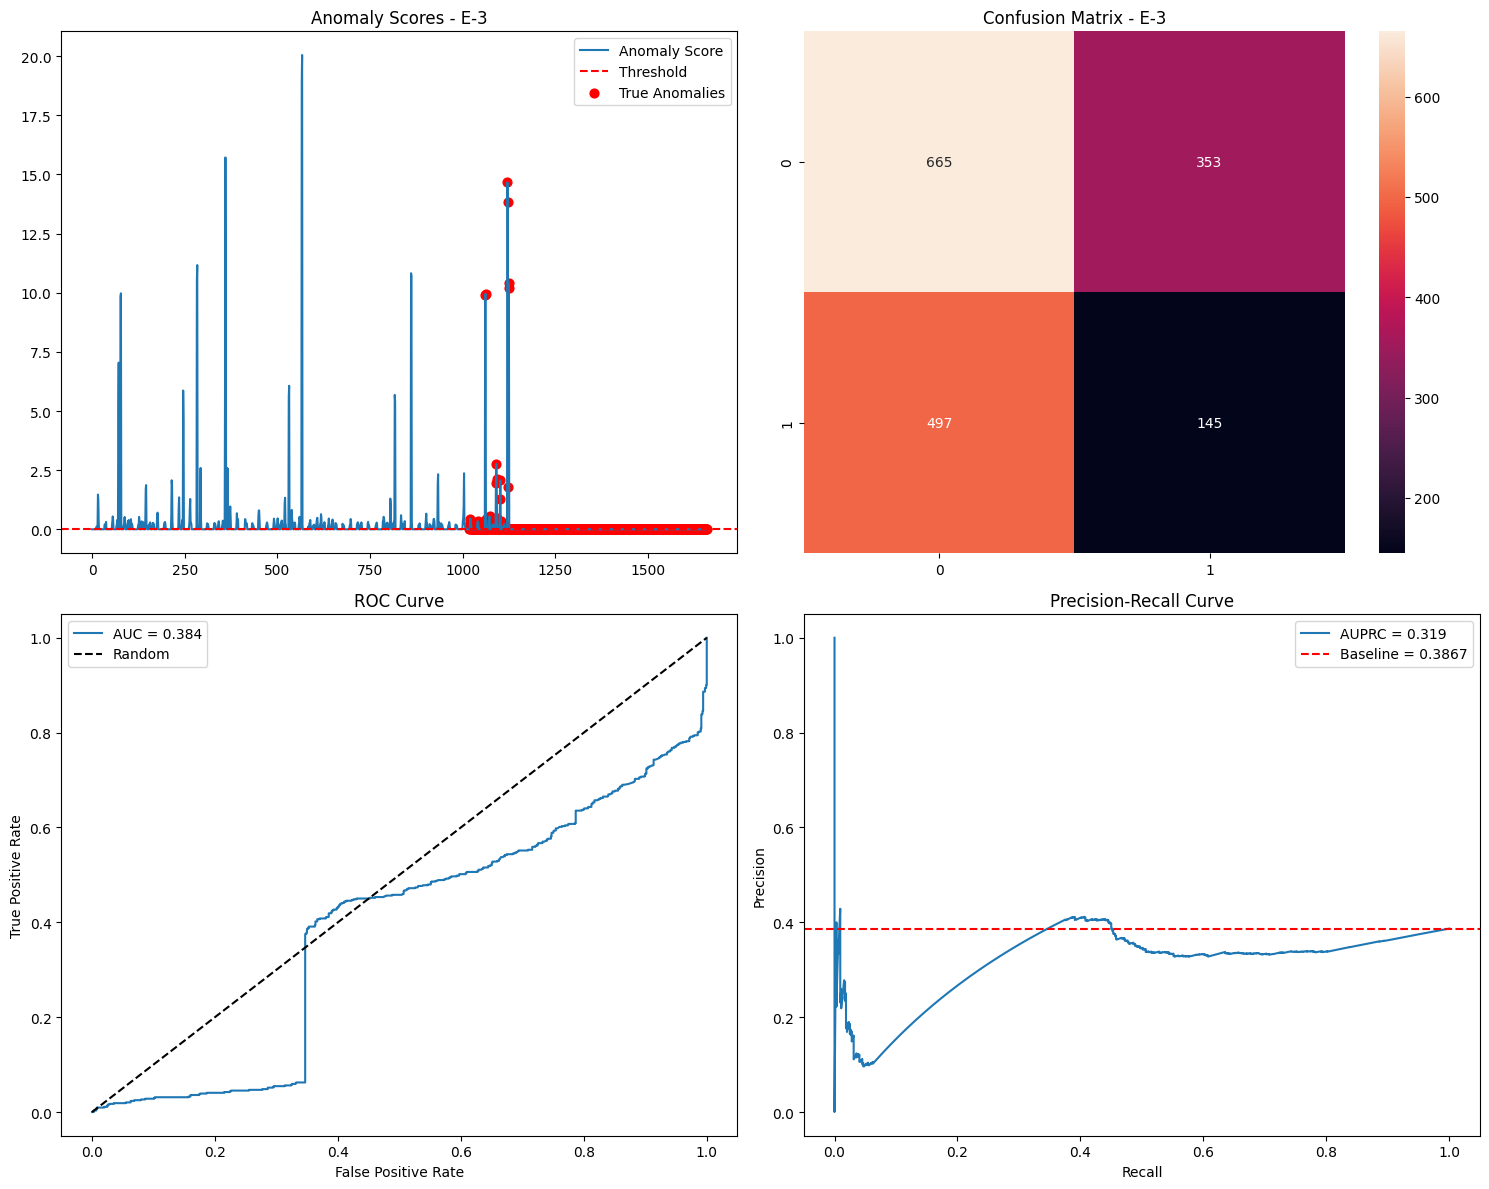


Metrics:
Accuracy: 0.488
Precision: 0.291
Recall: 0.226
F1: 0.254
AUROC: 0.384
AUPRC: 0.319 (Baseline: 0.3867)

Processing channel E-4
Channel E-4:
Total windows: 1669
Anomaly windows: 563
Anomaly class: 5    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.6473, Val Loss: 0.9790
Epoch 2, Train Loss: 0.6057, Val Loss: 0.9340
Epoch 3, Train Loss: 0.5706, Val Loss: 0.9074
Epoch 4, Train Loss: 0.5599, Val Loss: 0.8889
Epoch 5, Train Loss: 0.5727, Val Loss: 0.8759
Epoch 6, Train Loss: 0.5201, Val Loss: 0.8633
Epoch 7, Train Loss: 0.5187, Val Loss: 0.8547
Epoch 8, Train Loss: 0.4928, Val Loss: 0.8467
Epoch 9, Train Loss: 0.4952, Val Loss: 0.8387
Epoch 10, Train Loss: 0.4780, Val Loss: 0.8289
Epoch 11, Train Loss: 0.4796, Val Loss: 0.8252
Epoch 12, Train Loss: 0.4691, Val Loss: 0.8199
Epoch 13, Train Loss: 0.4788, Val Loss: 0.8127
Epoch 14, Train Loss: 0.4962, Val Loss: 0.8104
Epoch 15, Train Loss: 0.4843, Val Loss: 0.7989
Epoch 16, Train Loss: 0.4536, Val Loss: 0.7921
Epoch 17, Tr

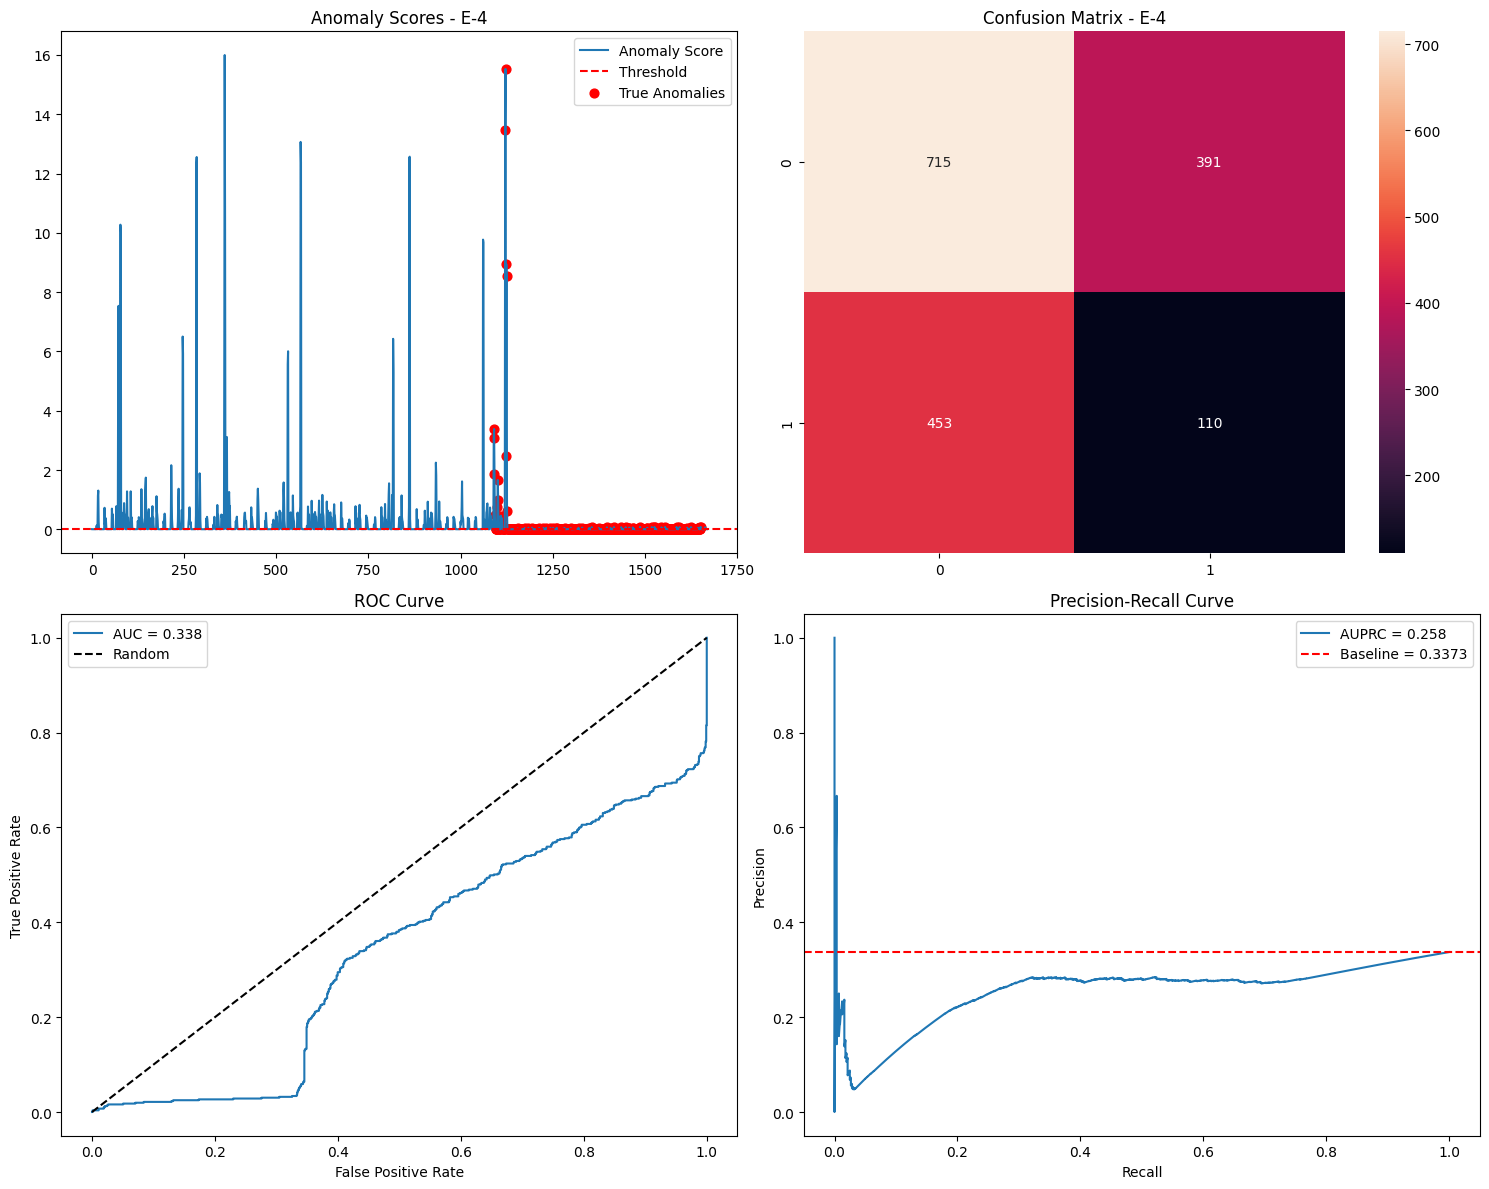


Metrics:
Accuracy: 0.494
Precision: 0.220
Recall: 0.195
F1: 0.207
AUROC: 0.338
AUPRC: 0.258 (Baseline: 0.3373)

Processing channel E-5
Channel E-5:
Total windows: 1657
Anomaly windows: 65
Anomaly class: 6    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-5 Insufficient anomaly windows

Processing channel E-6
Channel E-6:
Total windows: 1659
Anomaly windows: 14
Anomaly class: 7    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-6 Insufficient anomaly windows

Processing channel E-7
Channel E-7:
Total windows: 1661
Anomaly windows: 57
Anomaly class: 8    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-7 Insufficient anomaly windows

Processing channel E-8
Channel E-8:
Total windows: 1705
Anomaly windows: 125
Anomaly class: 9    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7727, Val Loss: 0.4524
Epoch 2, Train Loss: 0.8287, Val Loss: 0.4166
Epoch 3, Train Loss: 0.6967, Val Loss: 0.3923
Epoch 4, Train Loss: 0.6694, Val

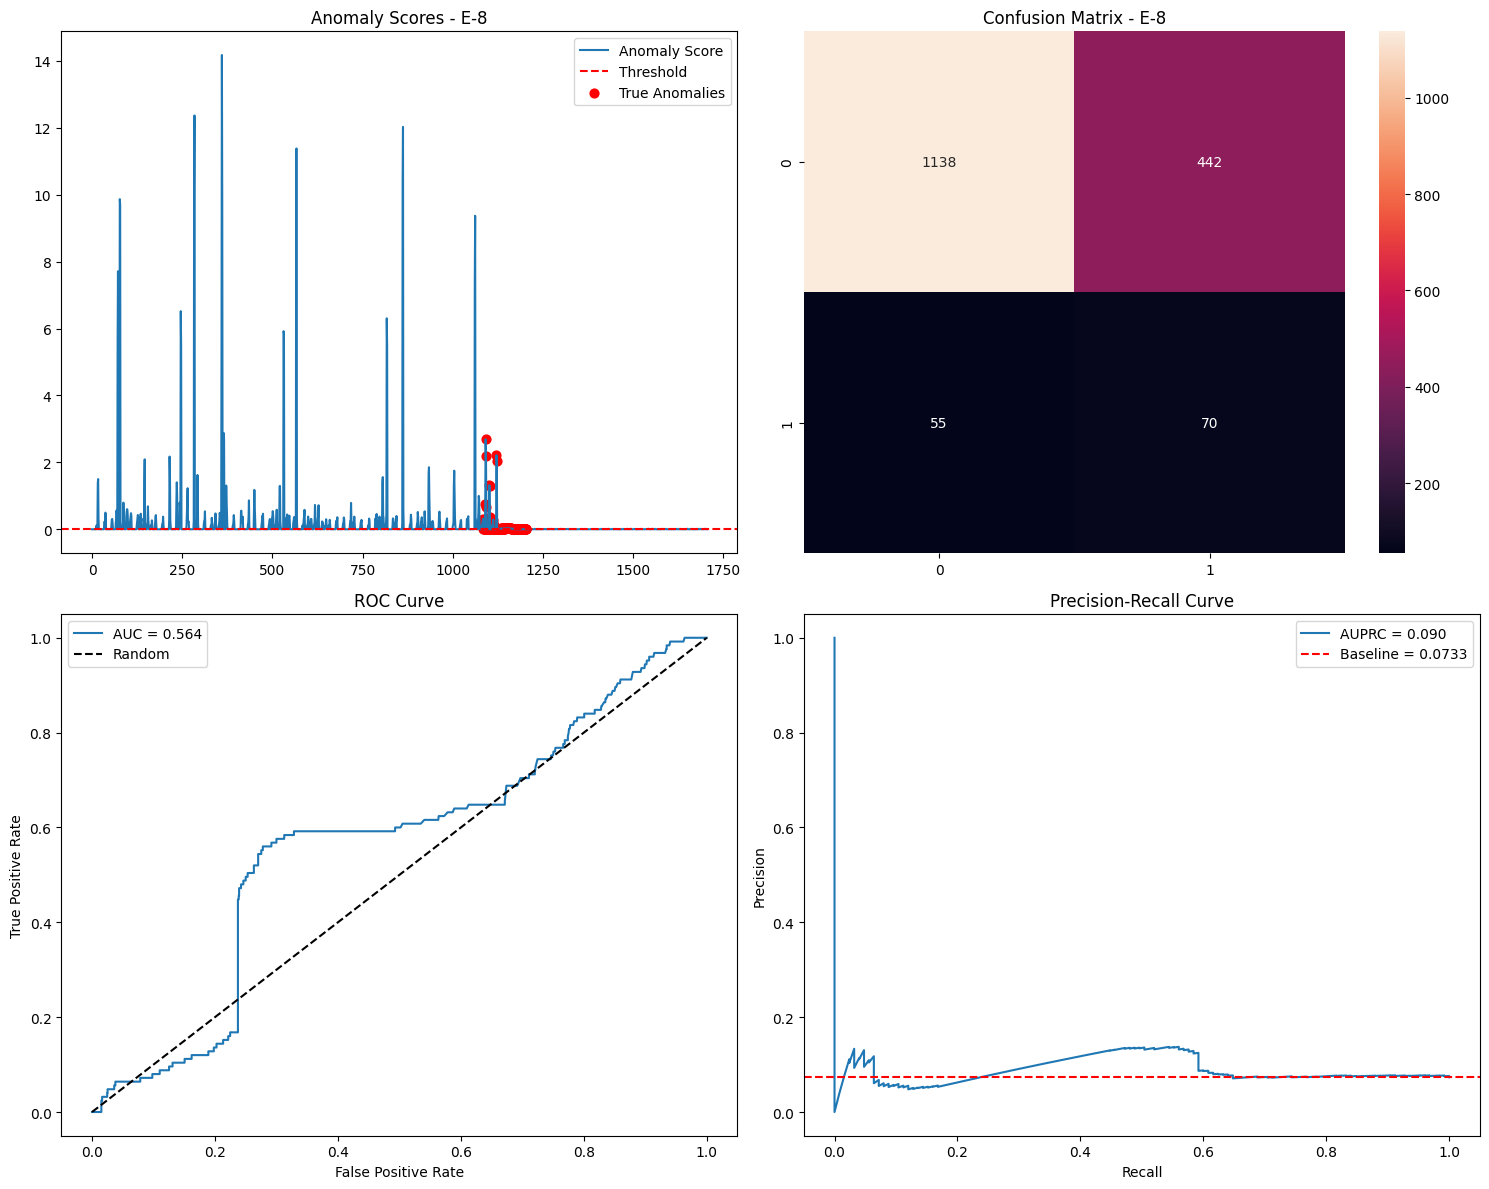


Metrics:
Accuracy: 0.709
Precision: 0.137
Recall: 0.560
F1: 0.220
AUROC: 0.564
AUPRC: 0.090 (Baseline: 0.0733)

Processing channel E-9
Channel E-9:
Total windows: 1659
Anomaly windows: 71
Anomaly class: 10    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel E-9 Insufficient anomaly windows

Processing channel F-1
Channel F-1:
Total windows: 1715
Anomaly windows: 21
Anomaly class: 30    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-1 Insufficient anomaly windows

Processing channel F-2
Channel F-2:
Total windows: 1724
Anomaly windows: 591
Anomaly class: 37    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.5548, Val Loss: 0.5170
Epoch 2, Train Loss: 0.5319, Val Loss: 0.4837
Epoch 3, Train Loss: 0.5118, Val Loss: 0.4617
Epoch 4, Train Loss: 0.4985, Val Loss: 0.4480
Epoch 5, Train Loss: 0.4905, Val Loss: 0.4406
Epoch 6, Train Loss: 0.4863, Val Loss: 0.4359
Epoch 7, Train Loss: 0.5075, Val Loss: 0.4333
Epoch 8, Train Loss: 0.5102, Val Loss: 0

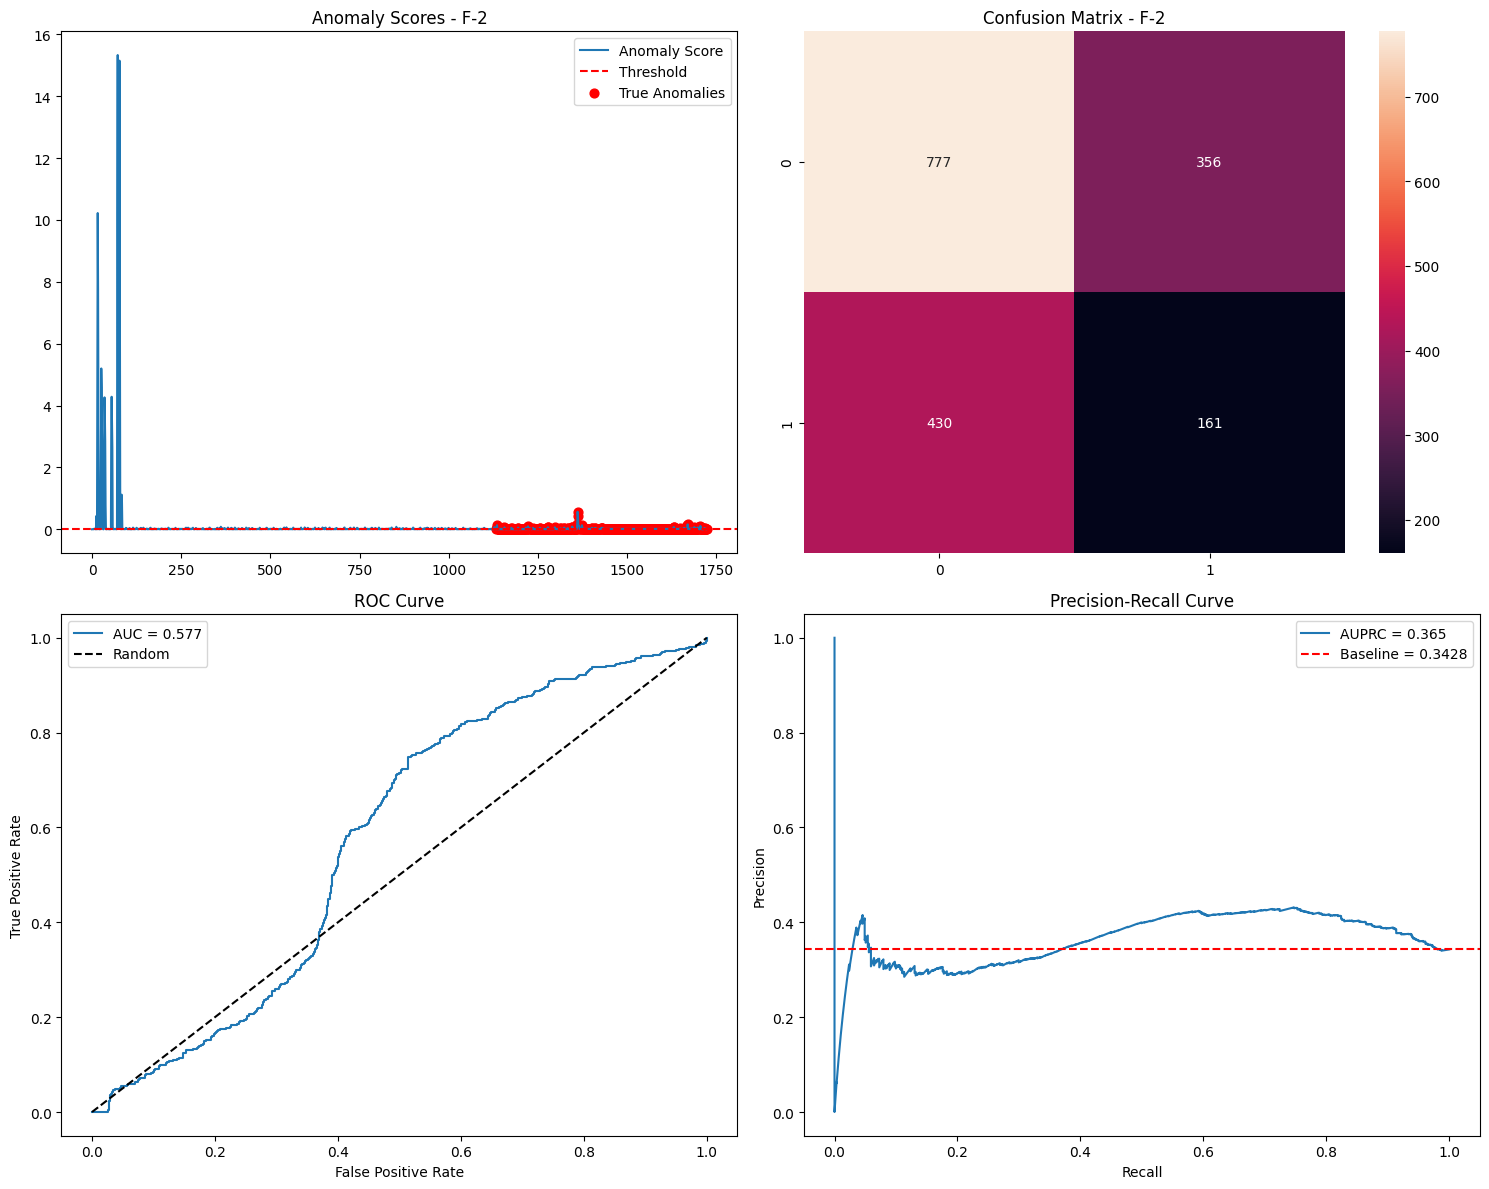


Metrics:
Accuracy: 0.544
Precision: 0.311
Recall: 0.272
F1: 0.291
AUROC: 0.577
AUPRC: 0.365 (Baseline: 0.3428)

Processing channel F-3
Channel F-3:
Total windows: 1674
Anomaly windows: 9
Anomaly class: 54    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-3 Insufficient anomaly windows

Processing channel F-4
Channel F-4:
Total windows: 683
Anomaly windows: 15
Anomaly class: 71    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-4 Insufficient anomaly windows

Processing channel F-5
Channel F-5:
Total windows: 783
Anomaly windows: 31
Anomaly class: 72    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-5 Insufficient anomaly windows

Processing channel F-7
Channel F-7:
Total windows: 1009
Anomaly windows: 87
Anomaly class: 62    [contextual, contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel F-7 Insufficient anomaly windows

Processing channel F-8
Channel F-8:
Total windows: 496
Anomaly windows: 

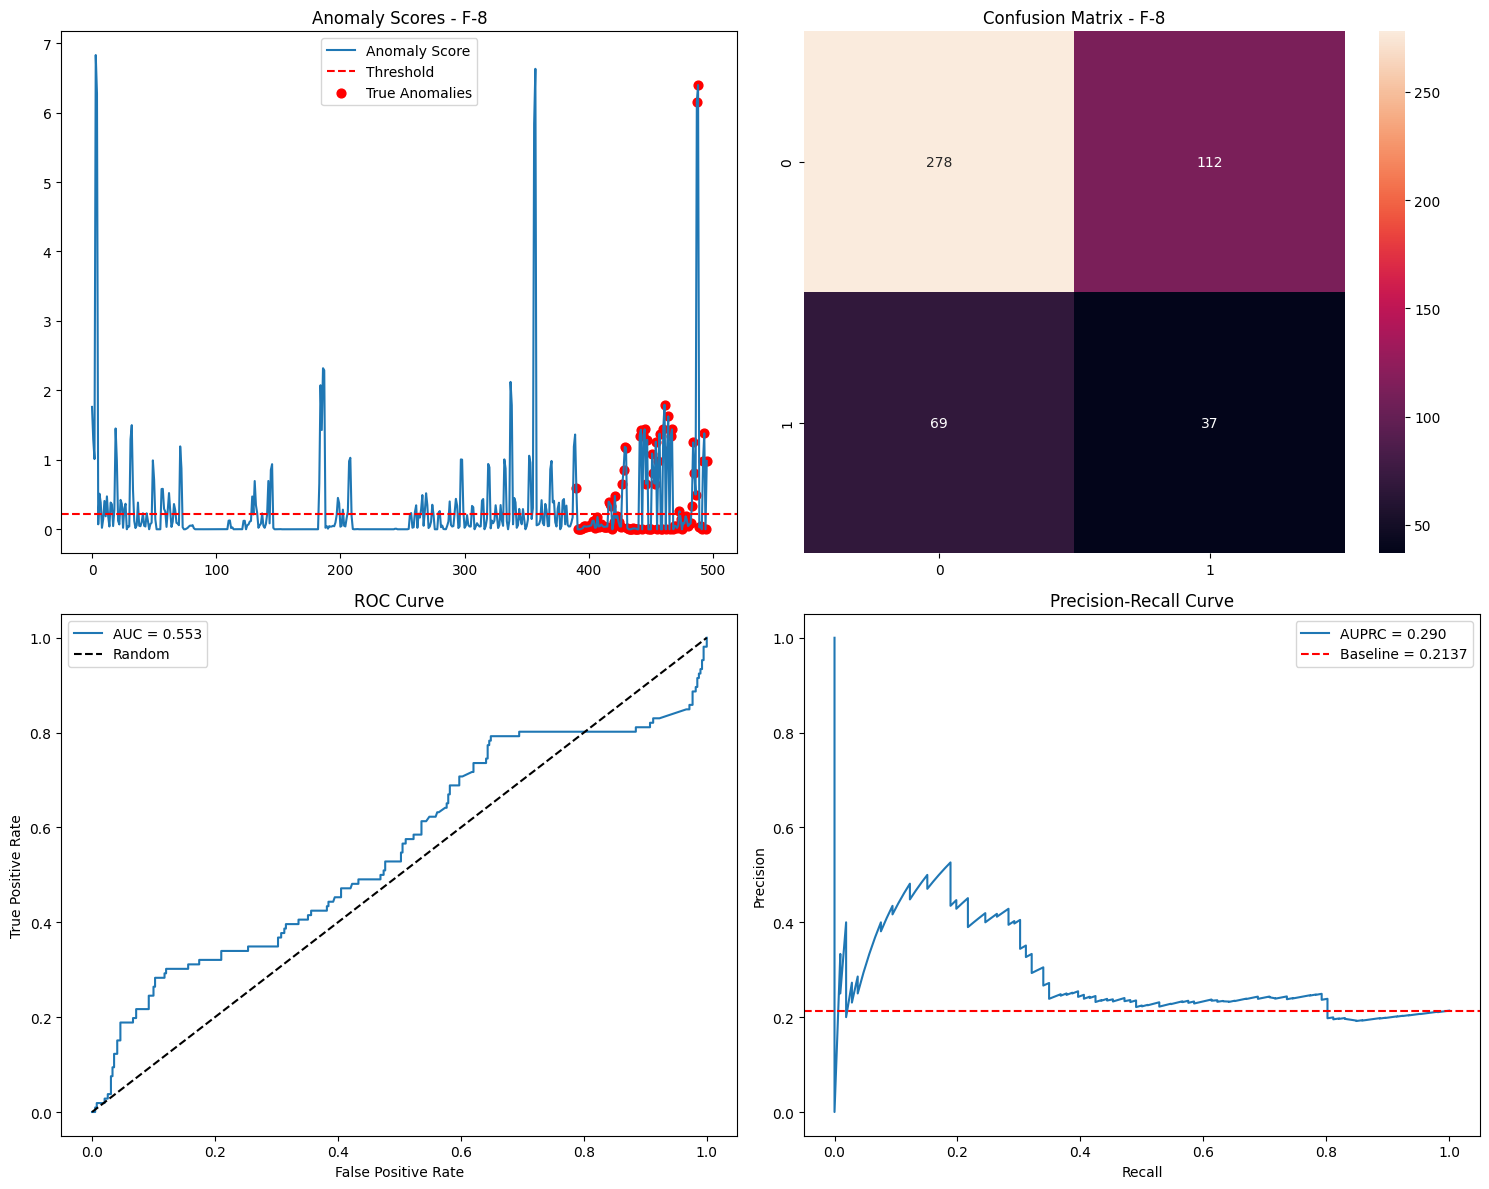


Metrics:
Accuracy: 0.635
Precision: 0.248
Recall: 0.349
F1: 0.290
AUROC: 0.553
AUPRC: 0.290 (Baseline: 0.2137)

Processing channel G-1
Channel G-1:
Total windows: 1692
Anomaly windows: 25
Anomaly class: 25    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel G-1 Insufficient anomaly windows

Processing channel G-2
Channel G-2:
Total windows: 1471
Anomaly windows: 9
Anomaly class: 26    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel G-2 Insufficient anomaly windows

Processing channel G-3
Channel G-3:
Total windows: 1580
Anomaly windows: 11
Anomaly class: 32    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel G-3 Insufficient anomaly windows

Processing channel G-4
Channel G-4:
Total windows: 1525
Anomaly windows: 7
Anomaly class: 38    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel G-4 Insufficient anomaly windows

Processing channel G-6
Channel G-6:
Total windows: 1727
Anomaly windows: 21
Anomaly class: 43    [po

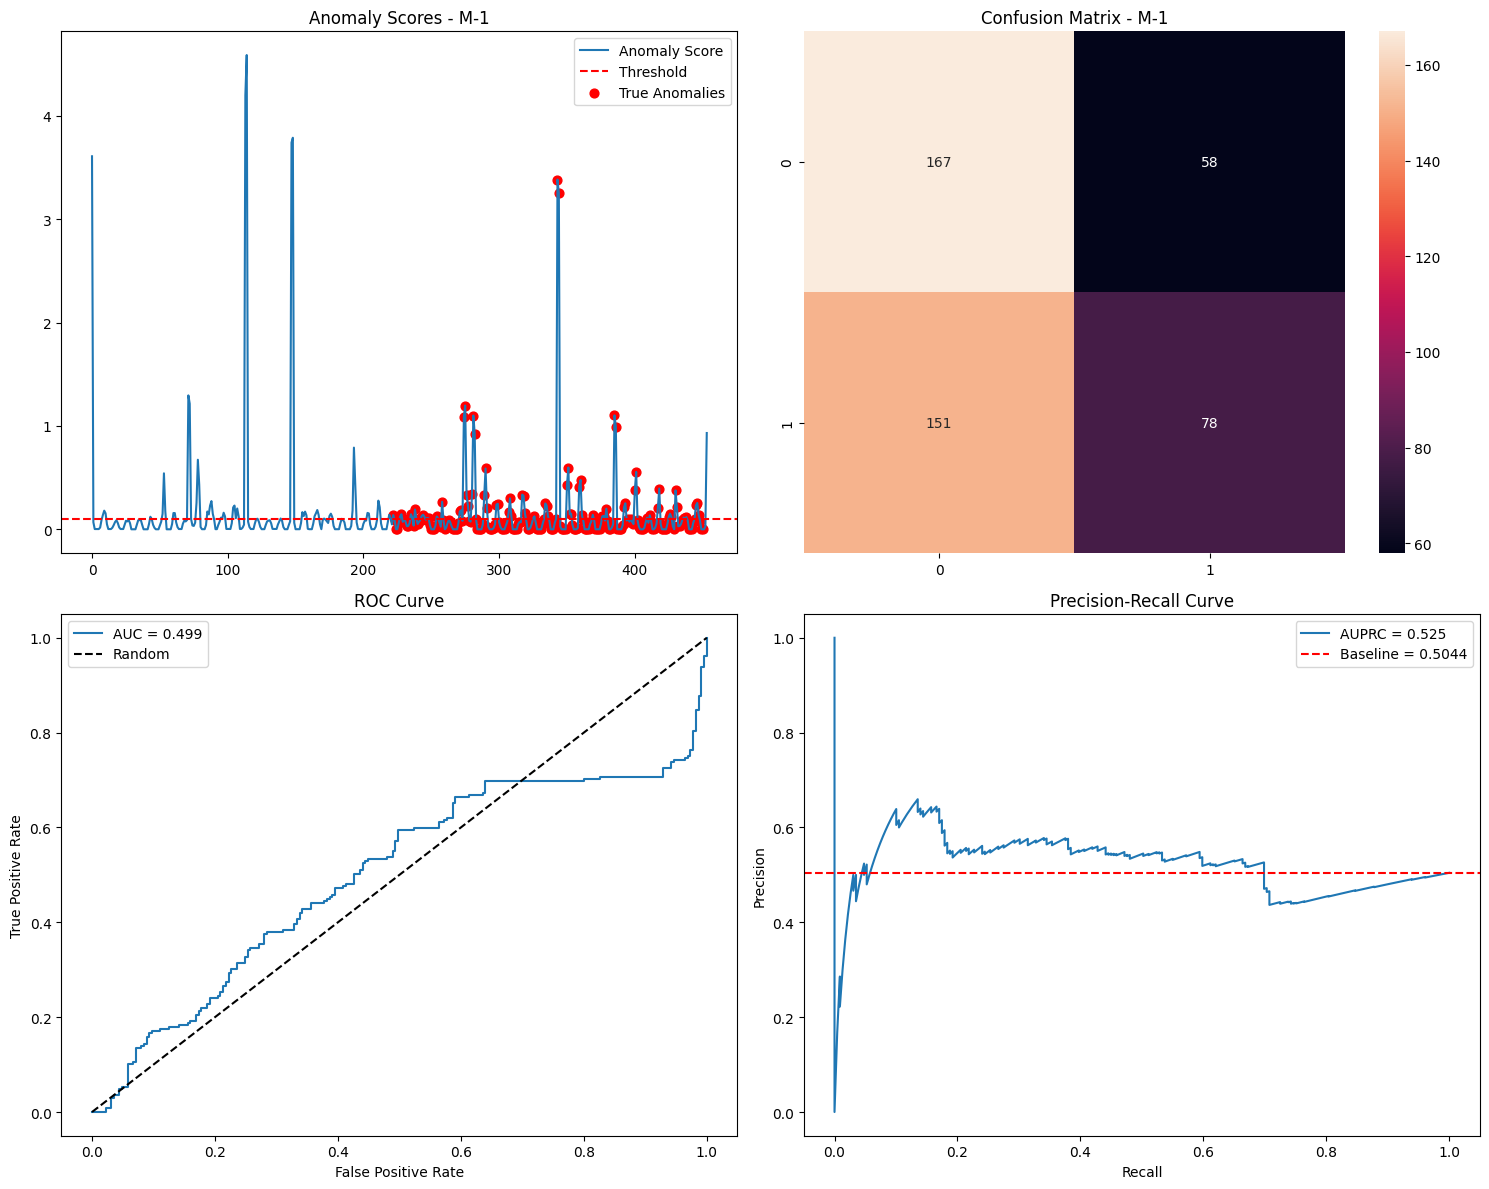


Metrics:
Accuracy: 0.540
Precision: 0.574
Recall: 0.341
F1: 0.427
AUROC: 0.499
AUPRC: 0.525 (Baseline: 0.5044)

Processing channel M-2
Channel M-2:
Total windows: 454
Anomaly windows: 229
Anomaly class: 57    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.2500, Val Loss: 0.1993
Epoch 2, Train Loss: 0.2468, Val Loss: 0.1953
Epoch 3, Train Loss: 0.2431, Val Loss: 0.1899
Epoch 4, Train Loss: 0.2386, Val Loss: 0.1848
Epoch 5, Train Loss: 0.2346, Val Loss: 0.1802
Epoch 6, Train Loss: 0.2312, Val Loss: 0.1769
Epoch 7, Train Loss: 0.2279, Val Loss: 0.1744
Epoch 8, Train Loss: 0.2253, Val Loss: 0.1729
Epoch 9, Train Loss: 0.2229, Val Loss: 0.1719
Epoch 10, Train Loss: 0.2210, Val Loss: 0.1713
Epoch 11, Train Loss: 0.2190, Val Loss: 0.1704
Epoch 12, Train Loss: 0.2172, Val Loss: 0.1697
Epoch 13, Train Loss: 0.2156, Val Loss: 0.1690
Epoch 14, Train Loss: 0.2141, Val Loss: 0.1686
Epoch 15, Train Loss: 0.2126, Val Loss: 0.1682
Epoch 16, Train Loss: 0.2114, Val Loss: 0.1678
Epoch 1

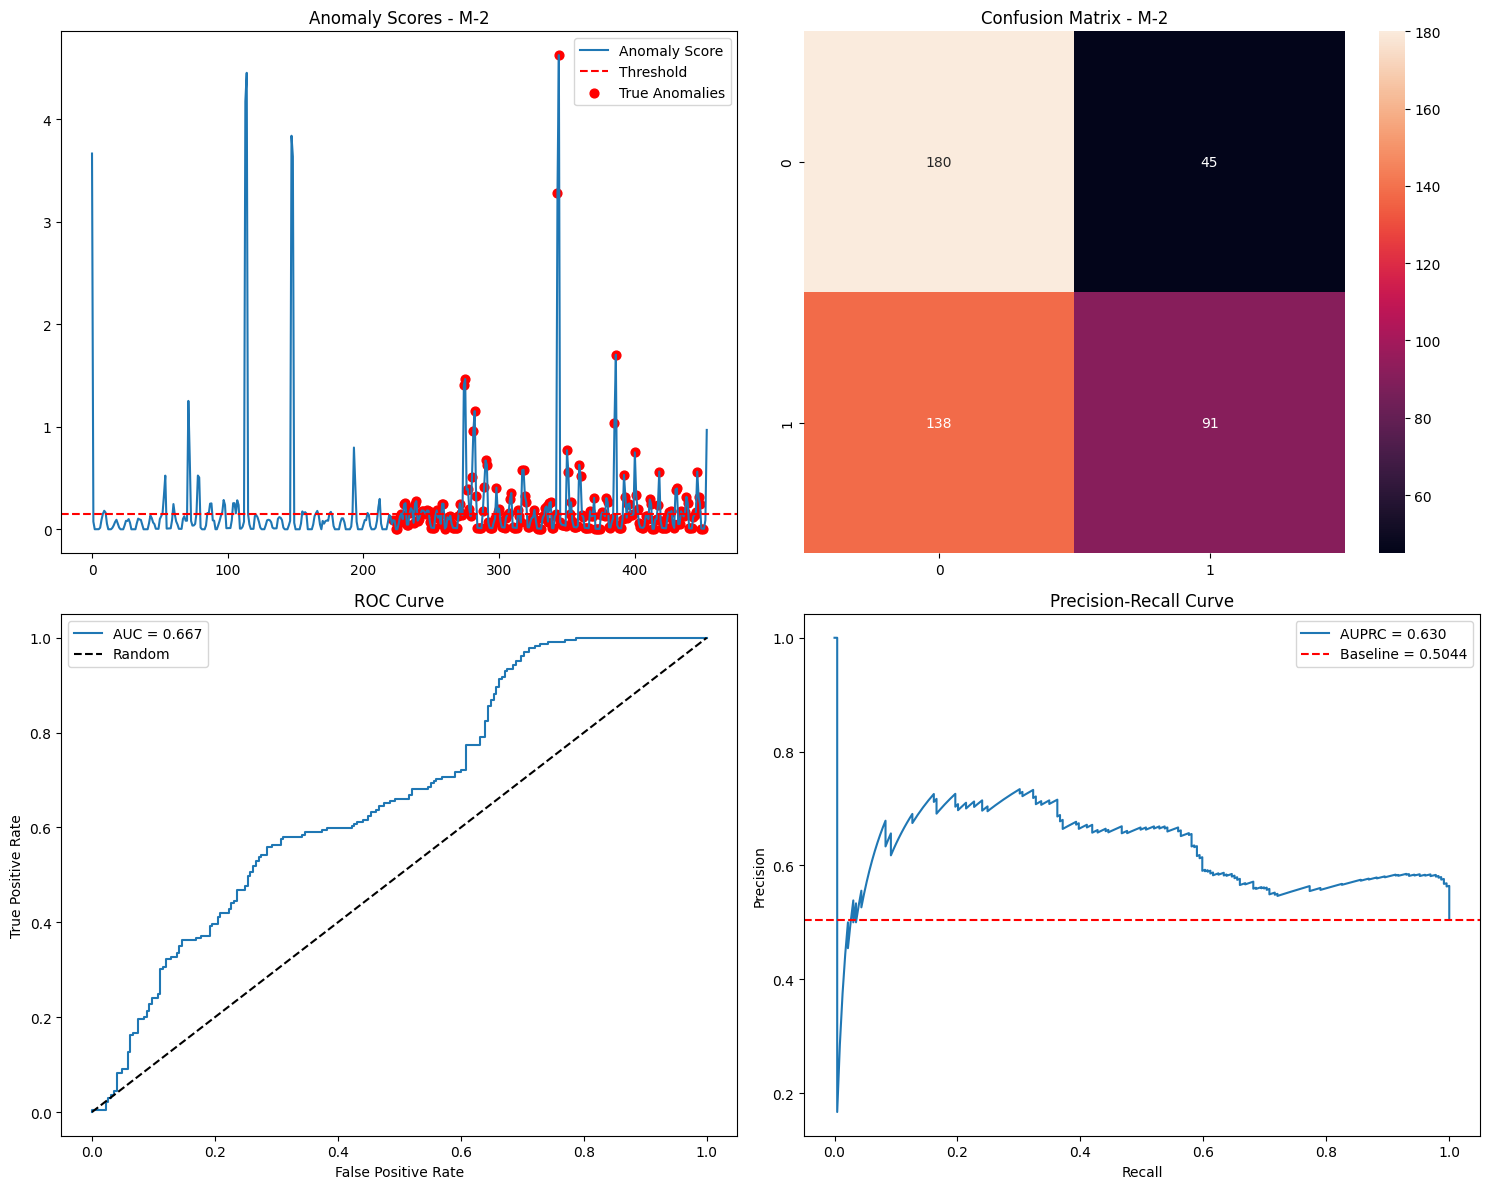


Metrics:
Accuracy: 0.597
Precision: 0.669
Recall: 0.397
F1: 0.499
AUROC: 0.667
AUPRC: 0.630 (Baseline: 0.5044)

Processing channel M-3
Channel M-3:
Total windows: 424
Anomaly windows: 51
Anomaly class: 63    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel M-3 Insufficient anomaly windows

Processing channel M-4
Channel M-4:
Total windows: 406
Anomaly windows: 51
Anomaly class: 64    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel M-4 Insufficient anomaly windows

Processing channel M-5
Channel M-5:
Total windows: 459
Anomaly windows: 61
Anomaly class: 65    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel M-5 Insufficient anomaly windows

Processing channel M-6
Channel M-6:
Total windows: 408
Anomaly windows: 37
Anomaly class: 55    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel M-6 Insufficient anomaly windows

Processing channel M-7
Channel M-7:
Total windows: 430
Anomaly windows: 21
Anomaly class: 80

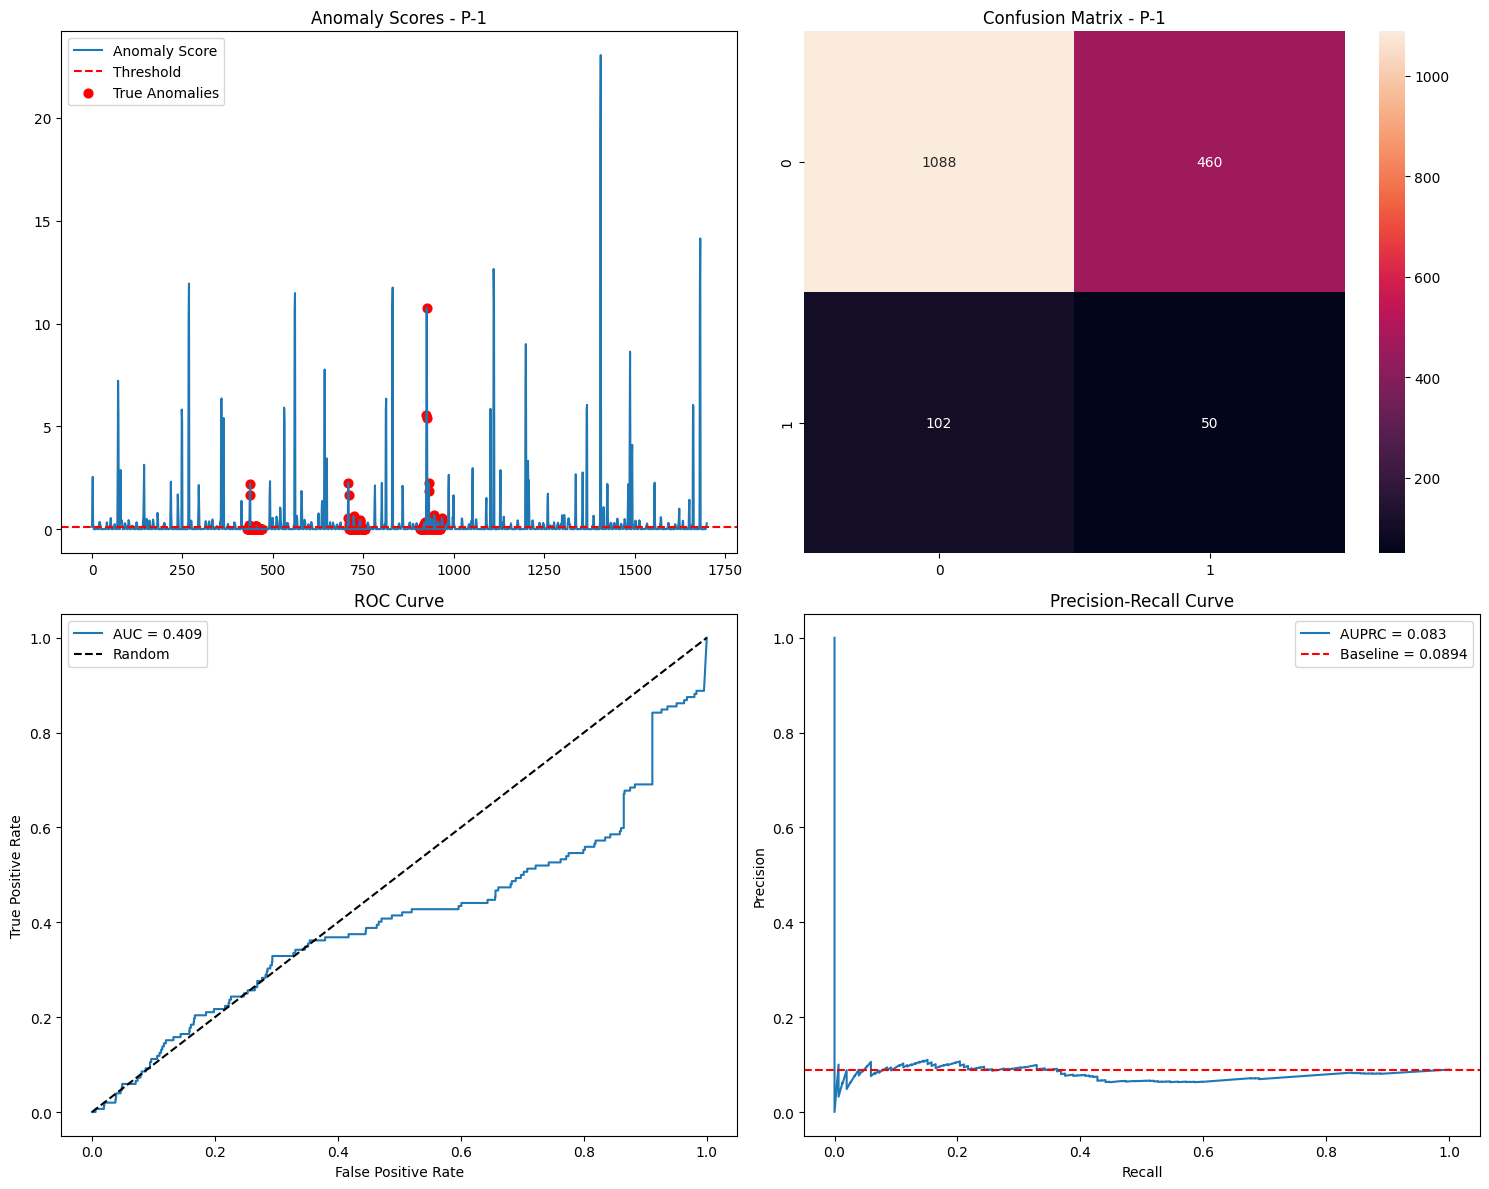


Metrics:
Accuracy: 0.669
Precision: 0.098
Recall: 0.329
F1: 0.151
AUROC: 0.409
AUPRC: 0.083 (Baseline: 0.0894)

Processing channel P-10
Channel P-10:
Total windows: 1219
Anomaly windows: 27
Anomaly class: 59    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-10 Insufficient anomaly windows

Processing channel P-11
Channel P-11:
Total windows: 706
Anomaly windows: 47
Anomaly class: 77    [point, point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-11 Insufficient anomaly windows

Processing channel P-14
Channel P-14:
Total windows: 1219
Anomaly windows: 37
Anomaly class: 75    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-14 Insufficient anomaly windows

Processing channel P-15
Channel P-15:
Total windows: 570
Anomaly windows: 5
Anomaly class: 66    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-15 Insufficient anomaly windows

Processing channel P-2
Channel P-2:
Total windows: 1640
Anomaly windows: 246
Anomaly cl

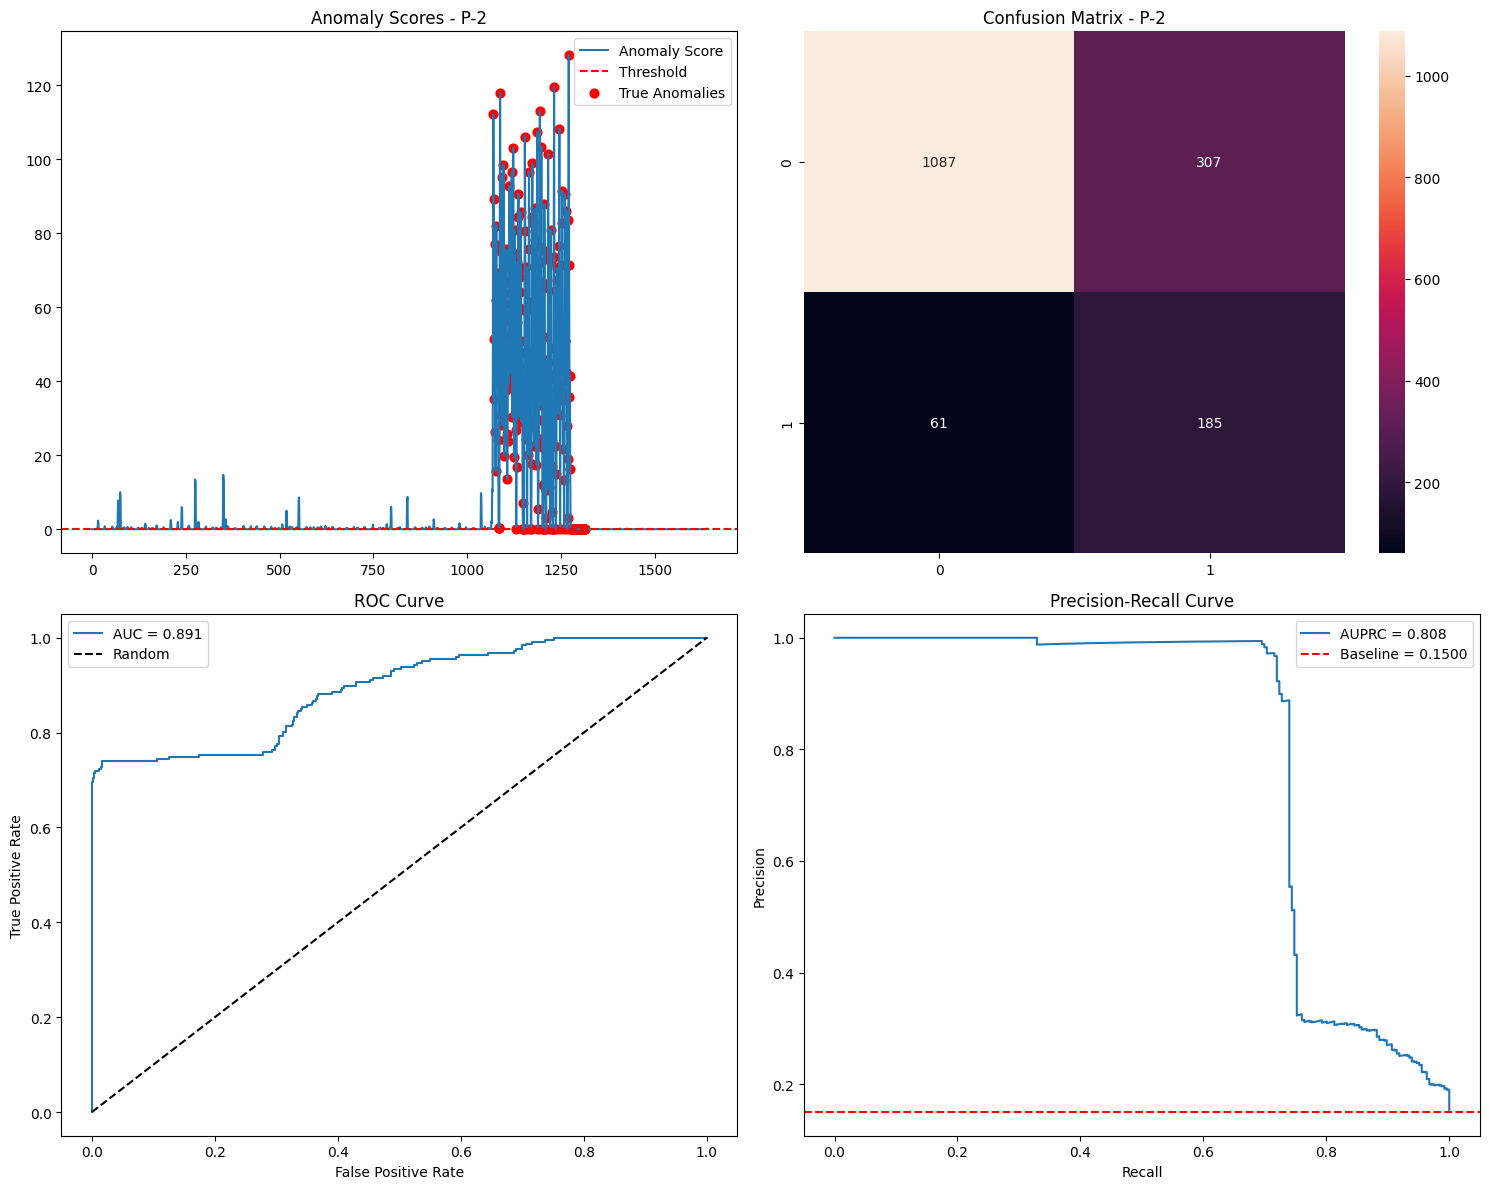


Metrics:
Accuracy: 0.776
Precision: 0.376
Recall: 0.752
F1: 0.501
AUROC: 0.891
AUPRC: 0.808 (Baseline: 0.1500)

Processing channel P-3
Channel P-3:
Total windows: 1697
Anomaly windows: 268
Anomaly class: 18    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.7782, Val Loss: 0.6417
Epoch 2, Train Loss: 0.7578, Val Loss: 0.6070
Epoch 3, Train Loss: 0.6456, Val Loss: 0.5802
Epoch 4, Train Loss: 0.7120, Val Loss: 0.5655
Epoch 5, Train Loss: 0.6414, Val Loss: 0.5554
Epoch 6, Train Loss: 0.6249, Val Loss: 0.5510
Epoch 7, Train Loss: 0.5875, Val Loss: 0.5457
Epoch 8, Train Loss: 0.5883, Val Loss: 0.5430
Epoch 9, Train Loss: 0.5947, Val Loss: 0.5349
Epoch 10, Train Loss: 0.5750, Val Loss: 0.5330
Epoch 11, Train Loss: 0.5675, Val Loss: 0.5293
Epoch 12, Train Loss: 0.5649, Val Loss: 0.5223
Epoch 13, Train Loss: 0.5840, Val Loss: 0.5201
Epoch 14, Train Loss: 0.5716, Val Loss: 0.5176
Epoch 15, Train Loss: 0.5527, Val Loss: 0.5133
Epoch 16, Train Loss: 0.6116, Val Loss: 0.5064
Epoch 17, T

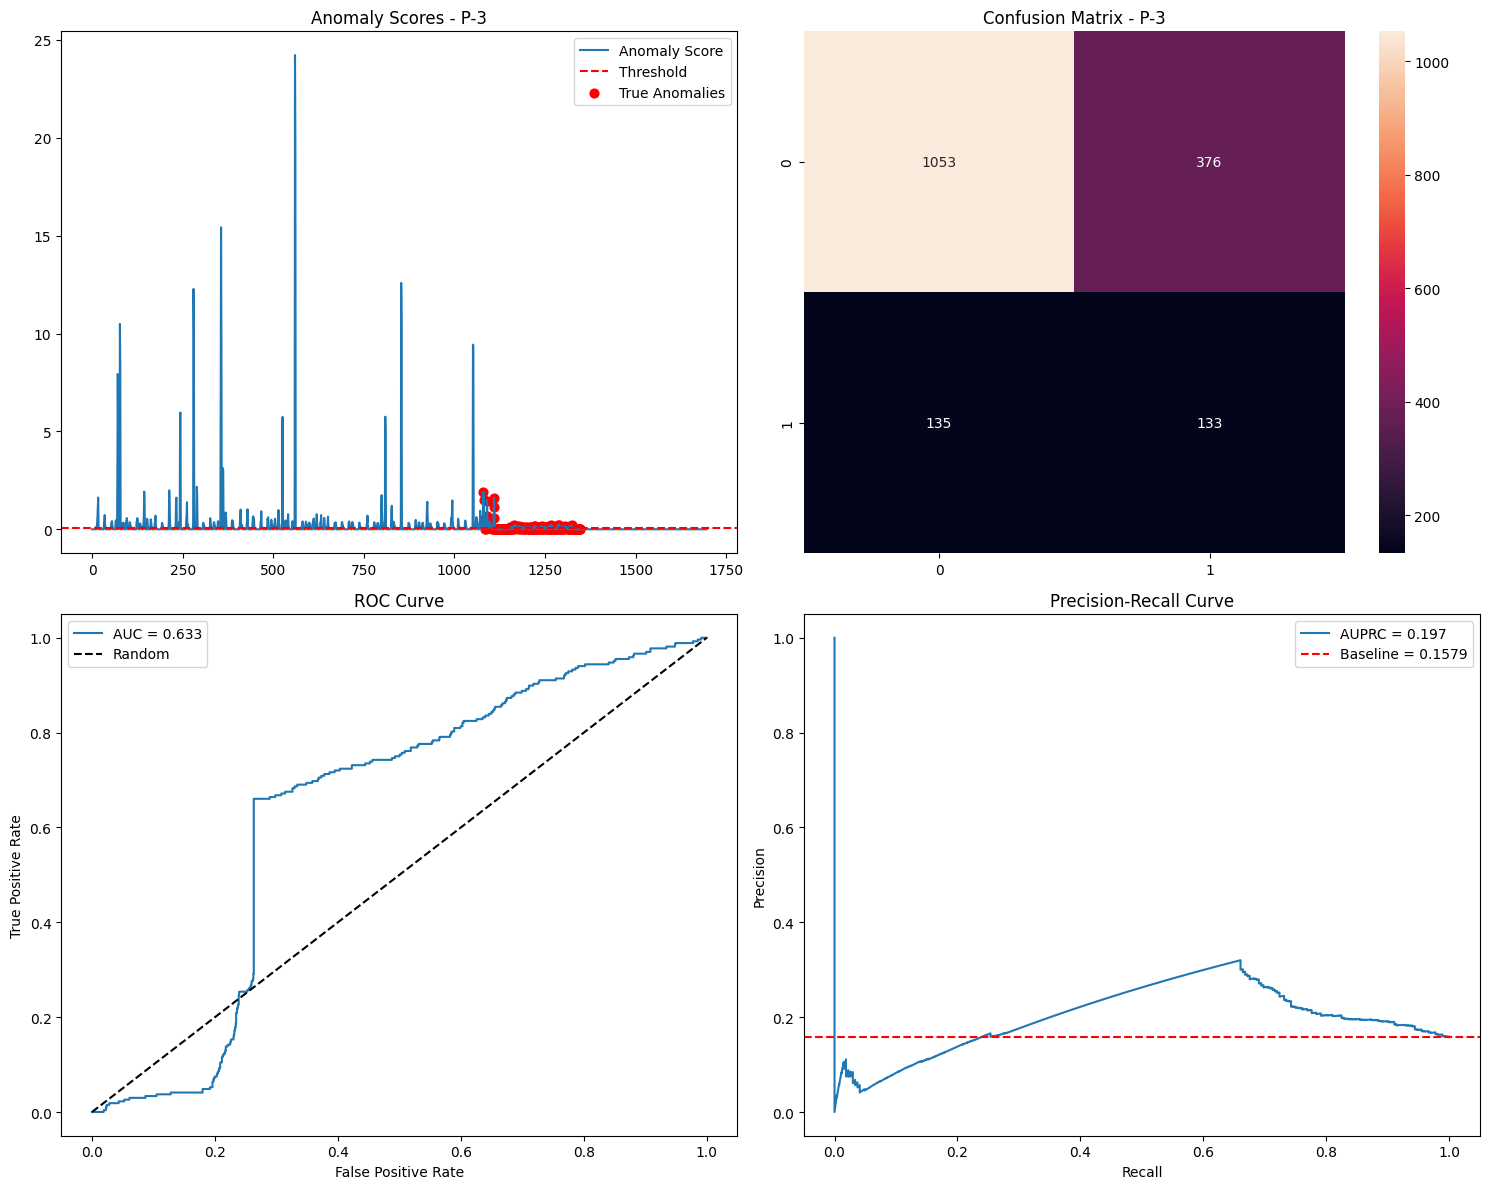


Metrics:
Accuracy: 0.699
Precision: 0.261
Recall: 0.496
F1: 0.342
AUROC: 0.633
AUPRC: 0.197 (Baseline: 0.1579)

Processing channel P-4
Channel P-4:
Total windows: 1555
Anomaly windows: 91
Anomaly class: 31    [point, point, point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel P-4 Insufficient anomaly windows

Processing channel P-7
Channel P-7:
Total windows: 1613
Anomaly windows: 331
Anomaly class: 45    [contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.3181, Val Loss: 0.1908
Epoch 2, Train Loss: 0.2916, Val Loss: 0.1632
Epoch 3, Train Loss: 0.2600, Val Loss: 0.1456
Epoch 4, Train Loss: 0.2438, Val Loss: 0.1397
Epoch 5, Train Loss: 0.2371, Val Loss: 0.1334
Epoch 6, Train Loss: 0.2690, Val Loss: 0.1324
Epoch 7, Train Loss: 0.2376, Val Loss: 0.1318
Epoch 8, Train Loss: 0.3388, Val Loss: 0.1298
Epoch 9, Train Loss: 0.2260, Val Loss: 0.1279
Epoch 10, Train Loss: 0.2887, Val Loss: 0.1264
Epoch 11, Train Loss: 0.2421, Val Loss: 0.1265
Epoch 12, Train Loss: 0.2318, V

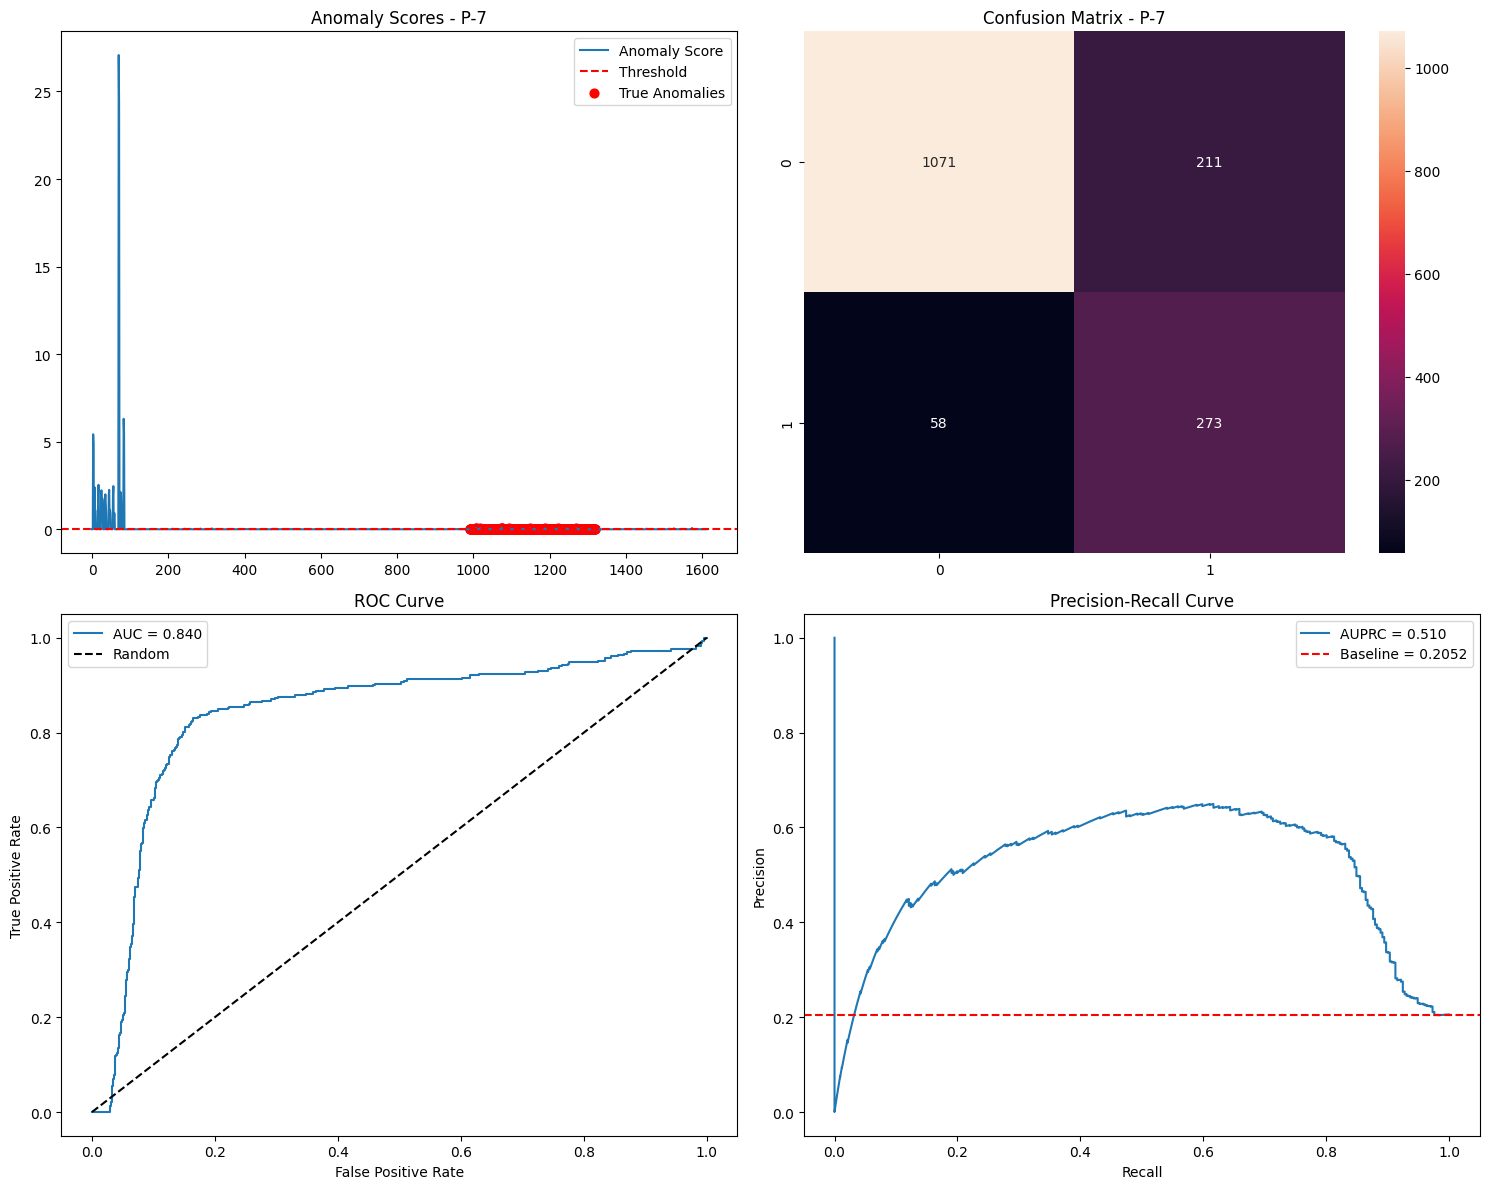


Metrics:
Accuracy: 0.833
Precision: 0.564
Recall: 0.825
F1: 0.670
AUROC: 0.840
AUPRC: 0.510 (Baseline: 0.2052)

Processing channel R-1
Channel R-1:
Total windows: 1447
Anomaly windows: 17
Anomaly class: 46    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel R-1 Insufficient anomaly windows

Processing channel S-1
Channel S-1:
Total windows: 1465
Anomaly windows: 90
Anomaly class: 1    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel S-1 Insufficient anomaly windows

Processing channel S-2
Channel S-2:
Total windows: 364
Anomaly windows: 3
Anomaly class: 58    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel S-2 Insufficient anomaly windows

Processing channel T-1
Channel T-1:
Total windows: 1721
Anomaly windows: 309
Anomaly class: 33    [point, contextual]
Name: class, dtype: object
Epoch 1, Train Loss: 0.0880, Val Loss: 0.0252
Epoch 2, Train Loss: 0.0678, Val Loss: 0.0112
Epoch 3, Train Loss: 0.0567, Val Loss: 0.0066
Epoch 4, Train Loss

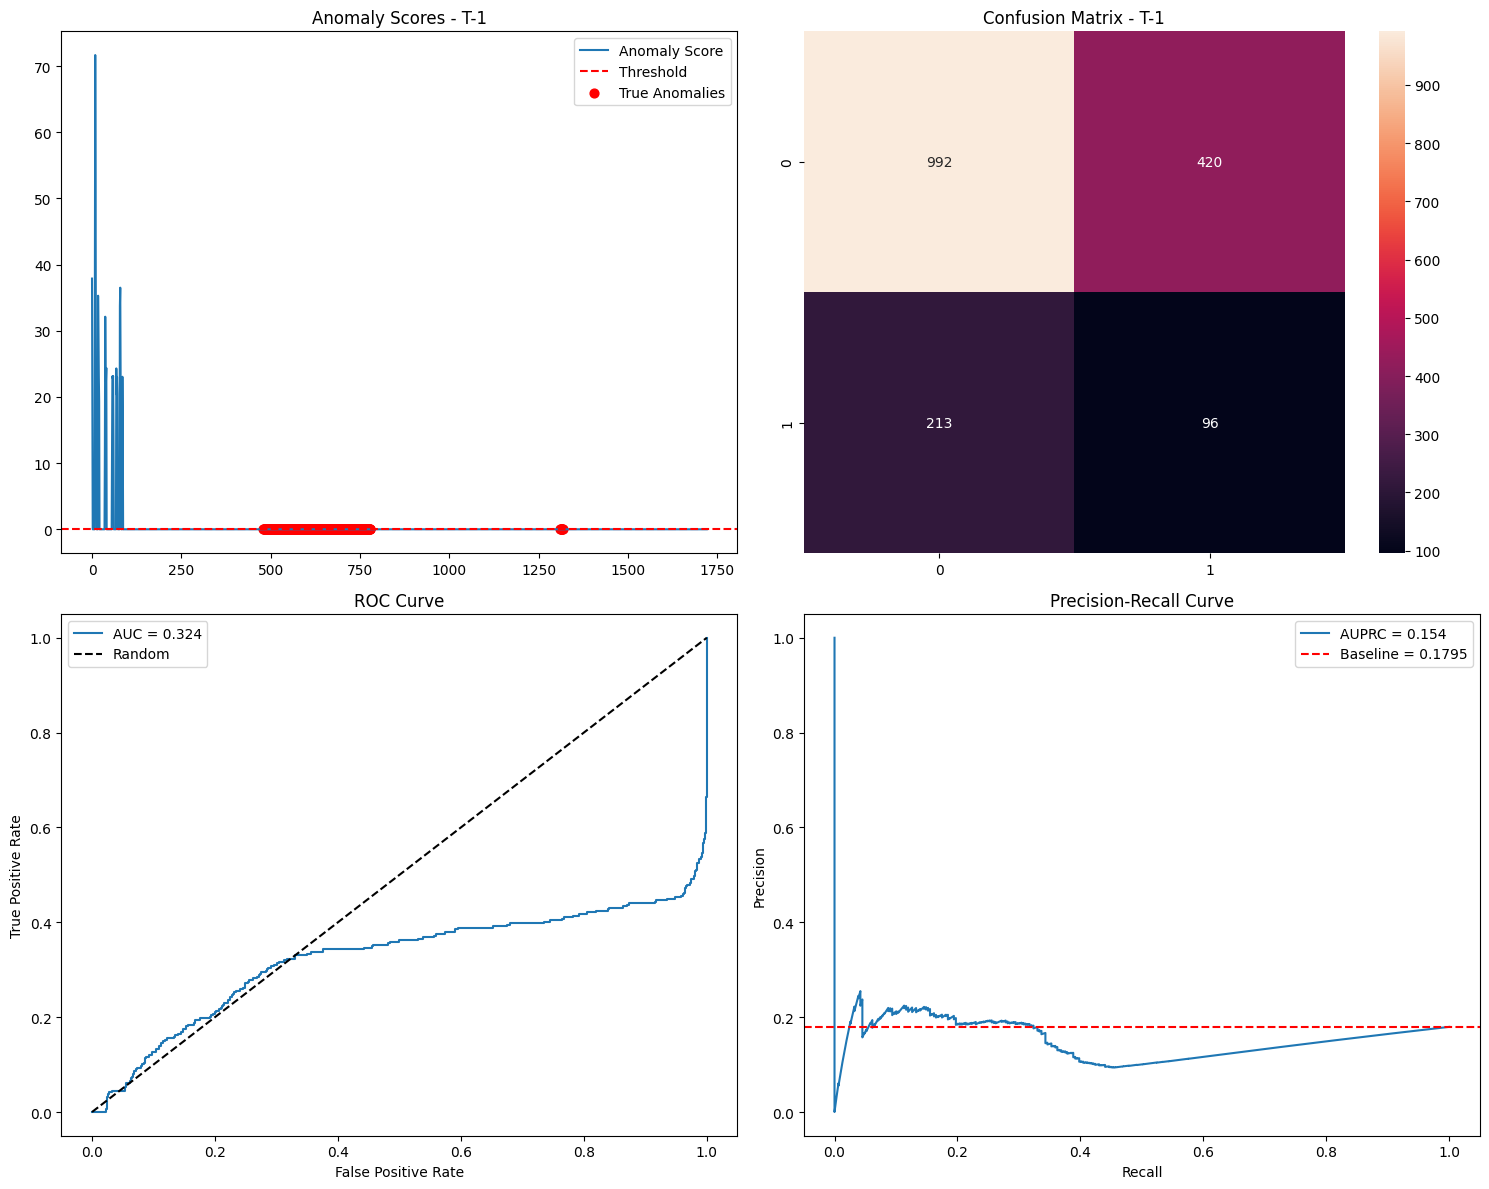


Metrics:
Accuracy: 0.632
Precision: 0.186
Recall: 0.311
F1: 0.233
AUROC: 0.324
AUPRC: 0.154 (Baseline: 0.1795)

Processing channel T-10

⚠️ WARNING: No labels found for channel T-10

Processing channel T-12
Channel T-12:
Total windows: 485
Anomaly windows: 25
Anomaly class: 69    [contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-12 Insufficient anomaly windows

Processing channel T-13
Channel T-13:
Total windows: 485
Anomaly windows: 52
Anomaly class: 70    [contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-13 Insufficient anomaly windows

Processing channel T-2
Channel T-2:
Total windows: 1724
Anomaly windows: 356
Anomaly class: 34    [point]
Name: class, dtype: object
Epoch 1, Train Loss: 0.5447, Val Loss: 0.4869
Epoch 2, Train Loss: 0.7643, Val Loss: 0.4582
Epoch 3, Train Loss: 0.4915, Val Loss: 0.4337
Epoch 4, Train Loss: 0.4685, Val Loss: 0.4190
Epoch 5, Train Loss: 0.4521, Val Loss: 0.4129
Epoch 6, Train Loss: 0.5131, Val Lo

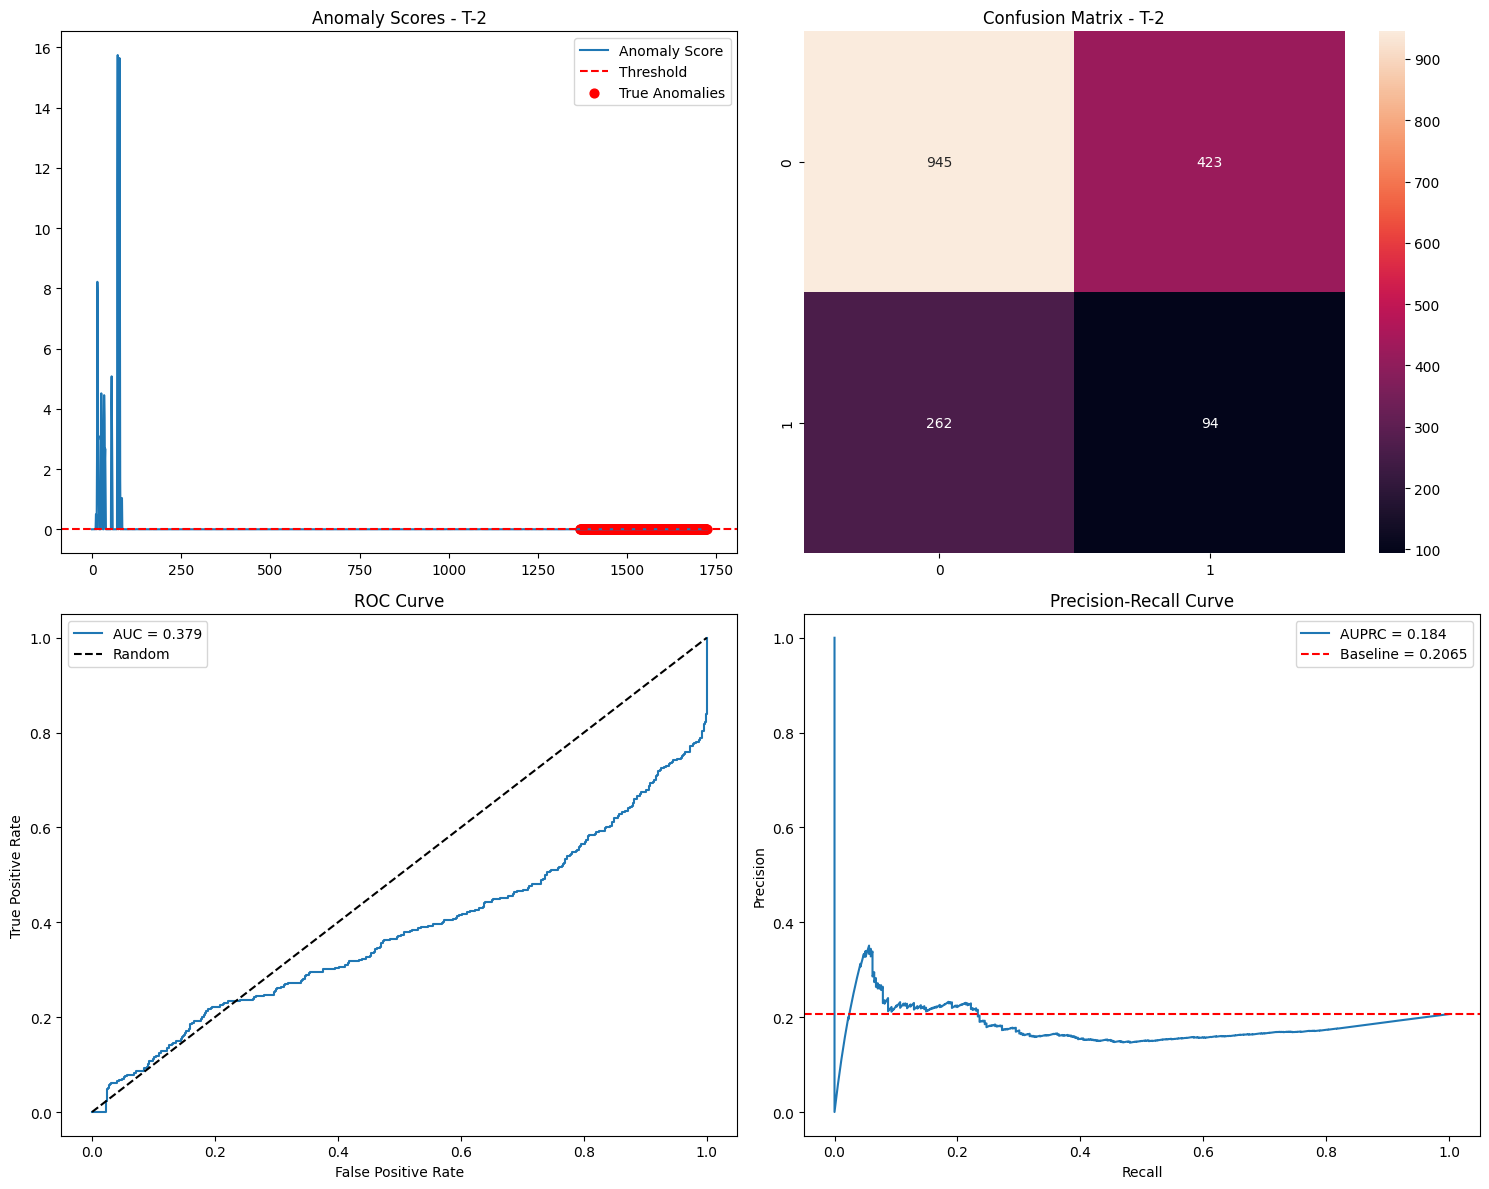


Metrics:
Accuracy: 0.603
Precision: 0.182
Recall: 0.264
F1: 0.215
AUROC: 0.379
AUPRC: 0.184 (Baseline: 0.2065)

Processing channel T-3
Channel T-3:
Total windows: 1714
Anomaly windows: 39
Anomaly class: 39    [point, point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-3 Insufficient anomaly windows

Processing channel T-4
Channel T-4:
Total windows: 442
Anomaly windows: 15
Anomaly class: 60    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-4 Insufficient anomaly windows

Processing channel T-5
Channel T-5:
Total windows: 442
Anomaly windows: 6
Anomaly class: 61    [point]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-5 Insufficient anomaly windows

Processing channel T-8
Channel T-8:
Total windows: 302
Anomaly windows: 22
Anomaly class: 76    [contextual, contextual]
Name: class, dtype: object

⚠️ WARNING: Skipping channel T-8 Insufficient anomaly windows

Processing channel T-9
Channel T-9:
Total windows: 218
Anomaly windows: 24
Anomaly 

In [37]:
if __name__ == "__main__":
    results = process_all_channels()

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, average_precision_score

def compute_lstm_attention_metrics(results):
    """
    Compute average metrics across all channels for the LSTM-Attention model.
    """
    # Collect metrics for each channel
    channel_metrics = []
    
    for channel, result in results.items():
        scores = result['scores']
        predictions = result['predictions']
        labels = result['labels']
        
        # Calculate metrics
        precision = precision_score(labels, predictions, zero_division=0)
        recall = recall_score(labels, predictions, zero_division=0)
        f1 = f1_score(labels, predictions, zero_division=0)
        accuracy = accuracy_score(labels, predictions)
        auroc = roc_auc_score(labels, scores)
        auprc = average_precision_score(labels, scores)
        
        channel_metrics.append({
            'channel': channel,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'accuracy': accuracy,
            'auroc': auroc,
            'auprc': auprc
        })
    
    # Convert to DataFrame
    metrics_df = pd.DataFrame(channel_metrics)
    
    # Calculate and add average row
    avg_metrics = metrics_df.drop('channel', axis=1).mean().to_dict()
    avg_metrics['channel'] = 'AVERAGE'
    metrics_df = pd.concat([metrics_df, pd.DataFrame([avg_metrics])], ignore_index=True)
    
    # Format floating point numbers
    float_cols = ['precision', 'recall', 'f1', 'accuracy', 'auroc', 'auprc']
    metrics_df[float_cols] = metrics_df[float_cols].applymap(lambda x: f"{x:.4f}")
    
    # Print summary
    print(f"\n{'='*50}")
    print(f"LSTM-Attention Model: Average Metrics Across {len(channel_metrics)} Channels")
    print(f"{'='*50}")
    print(f"Precision: {float(avg_metrics['precision']):.4f}")
    print(f"Recall: {float(avg_metrics['recall']):.4f}")
    print(f"F1-Score: {float(avg_metrics['f1']):.4f}")
    print(f"Accuracy: {float(avg_metrics['accuracy']):.4f}")
    print(f"AUROC: {float(avg_metrics['auroc']):.4f}")
    print(f"AUPRC: {float(avg_metrics['auprc']):.4f}")
    
    return metrics_df




# Calculate average metrics
metrics_df = compute_lstm_attention_metrics(results)

# Display full results table
print("\nDetailed metrics by channel:")
print(metrics_df.to_string(index=False))




LSTM-Attention Model: Average Metrics Across 28 Channels
Precision: 0.4262
Recall: 0.4500
F1-Score: 0.4115
Accuracy: 0.6688
AUROC: 0.6230
AUPRC: 0.4390

Detailed metrics by channel:
channel precision recall     f1 accuracy  auroc  auprc
    A-7    0.5811 0.6258 0.6026   0.7699 0.8037 0.5031
    A-8    0.0896 0.0591 0.0713   0.2993 0.0538 0.2937
    A-9    0.5277 0.3459 0.4178   0.5585 0.4375 0.4882
    D-1    0.9922 0.7785 0.8724   0.9129 0.9414 0.9523
   D-12    0.9029 0.7313 0.8081   0.8799 0.9359 0.8987
   D-15    0.3333 0.3333 0.3333   0.6000 0.6246 0.3579
   D-16    0.3435 0.3435 0.3435   0.6064 0.5302 0.3420
    D-2    0.5569 0.3361 0.4192   0.5419 0.7667 0.6695
    D-3    0.9498 0.7500 0.8382   0.8900 0.9667 0.8620
    D-4    1.0000 0.7840 0.8789   0.9173 0.9978 0.9973
    D-7    0.4201 0.3414 0.3767   0.6012 0.7221 0.4729
    D-9    0.8222 0.8043 0.8132   0.9426 0.8722 0.6976
    E-1    0.1213 0.6019 0.2020   0.7121 0.6648 0.1118
   E-12    0.0518 0.2203 0.0839   0.6661 0.5753